In [1]:
import omicverse as ov
#import scvelo as scv
ov.ov_plot_set()



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.4, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [3]:
adata=ov.utils.read('data/placenta_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 64734 × 31764
    obs: 'Fetus', 'location', 'final_cluster', 'annotation'

In [ ]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata

In [ ]:
adata.var.index=[i.split('_')[0] for i in adata.var.index]

In [41]:
adata2=adata.copy()
adata2.raw = adata2
adata2 = adata2[:, adata2.var.highly_variable_features]
adata2

View of AnnData object with n_obs × n_vars = 64666 × 3000
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

In [42]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


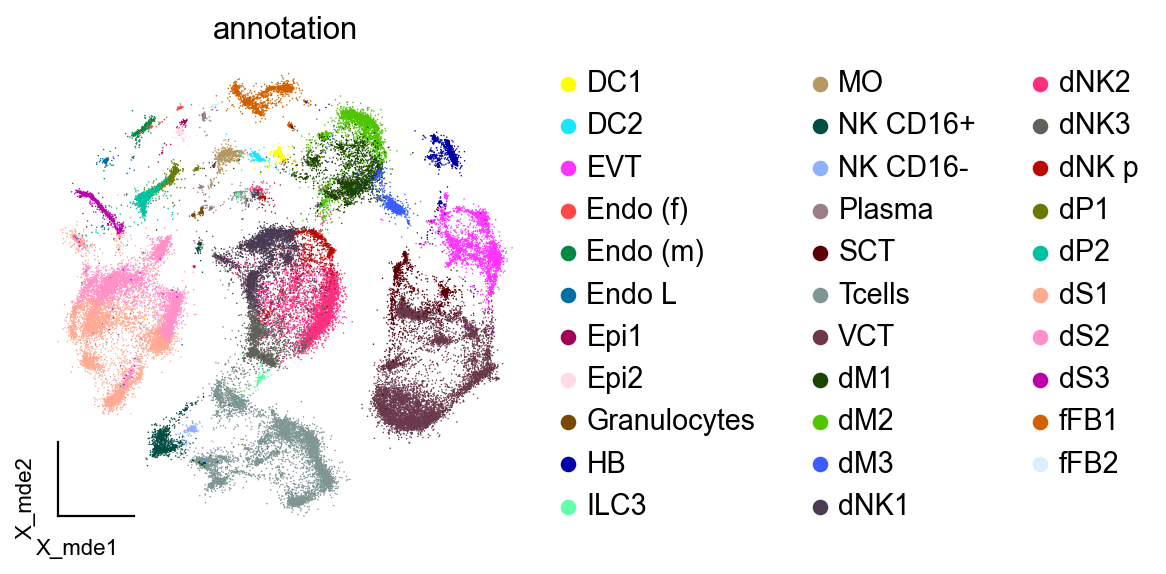

In [44]:
ov.utils.embedding(adata2,
                basis='X_mde',
                color='annotation',
                frameon='small')

In [49]:
import re
adata2.obs['celltype']=[re.sub(r'\d+$', '', item) for item in adata2.obs['annotation']]
adata2.obs['celltype']=[i.split(' ')[0] for i in adata2.obs['celltype']]

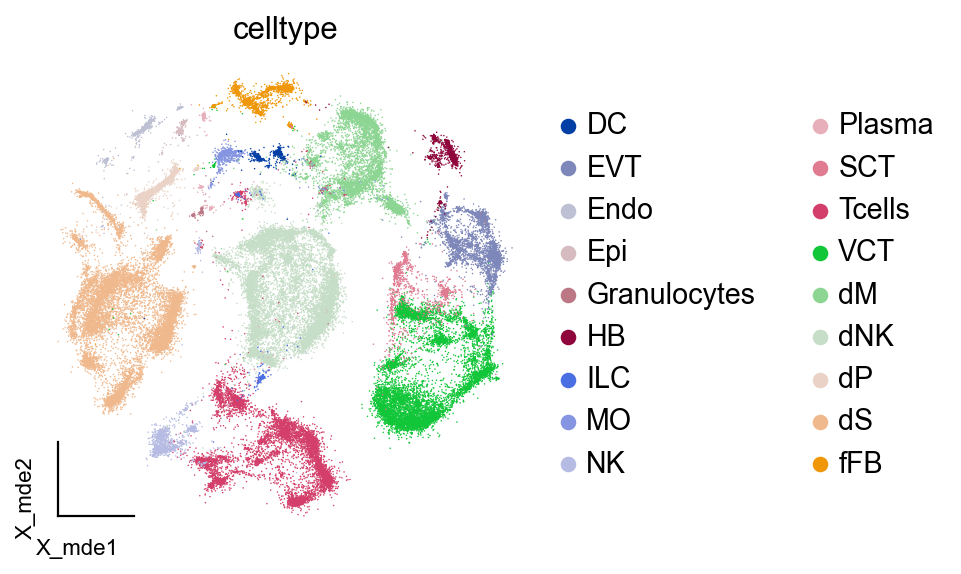

In [50]:
ov.utils.embedding(adata2,
                basis='X_mde',
                color='celltype',
                frameon='small')

In [6]:
import re
adata.obs['celltype']=[re.sub(r'\d+$', '', item) for item in adata.obs['annotation']]
adata.obs['celltype']=[i.split(' ')[0] for i in adata.obs['celltype']]
adata.obs['celltype']=adata.obs['celltype'].astype('category')

In [52]:
import scanpy as sc
import anndata
import pandas as pd
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata1=anndata.AnnData(adata.X,obs=pd.DataFrame(index=adata.obs.index),
                          var=pd.DataFrame(index=adata.var.index))

In [53]:
adata1.write_h5ad('data/placenta/norm_log.h5ad',compression='gzip')
adata

AnnData object with n_obs × n_vars = 64666 × 21002
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'celltype'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

In [54]:
#meta导出
df_meta = pd.DataFrame(data={'Cell':list(adata[adata1.obs.index].obs.index),
                             'cell_type':[ i for i in adata[adata1.obs.index].obs['celltype']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('data/placenta/meta.tsv', sep = '\t')

In [55]:
import os
os.getcwd() 

'/mnt/home/zehuazeng/analysis/cellfate'

## cellphone

In [6]:
import os
cpdb_file_path = '/mnt/home/zehuazeng/data/cellphonedb/cellphonedb.zip'
meta_file_path = os.getcwd()+'/data/placenta/meta.tsv'
counts_file_path = os.getcwd()+'/data/placenta/norm_log.h5ad'
microenvs_file_path = None
active_tf_path = None
out_path =os.getcwd()+'/data/placenta/adata_cellphone'

In [7]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 10,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
/mnt/home/zehuazeng/analysis/cellfate/data/placenta/norm_log.h5ad
/mnt/home/zehuazeng/analysis/cellfate/data/placenta/meta.tsv
[ ][CORE][04/07/24-15:40:02][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:10 Precision:3
[ ][CORE][04/07/24-15:40:02][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][04/07/24-15:40:05][INFO] Running Real Analysis
[ ][CORE][04/07/24-15:40:05][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [10:18<00:00,  1.62it/s]

[ ][CORE][04/07/24-15:50:24][INFO] Building Pvalues result


[ ][CORE][04/07/24-15:50:24][INFO] Building results
[ ][CORE][04/07/24-15:50:25][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 18/18 [00:00<00:00, 30.27it/s]

[ ][CORE][04/07/24-15:50:25][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 18/18 [00:00<00:00, 92.93it/s]


[ ][CORE][04/07/24-15:50:26][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 324/324 [00:43<00:00,  7.39it/s]


Saved deconvoluted to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_deconvoluted_07_04_2024_155111.txt
Saved deconvoluted_percents to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_deconvoluted_percents_07_04_2024_155111.txt
Saved means to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_means_07_04_2024_155111.txt
Saved pvalues to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_pvalues_07_04_2024_155111.txt
Saved significant_means to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_significant_means_07_04_2024_155111.txt
Saved interaction_scores to /mnt/home/zehuazeng/analysis/cellfate/data/placenta/adata_cellphone/statistical_analysis_interaction_scores_07_04_2024_155111.txt


In [8]:
ov.utils.save(cpdb_results,'data/cpdb/evt_cpdb_test.pkl')

In [9]:
import scanpy as sc
adata=sc.read('data/placenta/adata_preprocess.h5ad')

In [10]:
interaction=ov.single.cpdb_network_cal(adata = adata,
        pvals = cpdb_results['pvalues'],
        celltype_key = "celltype",)   

ktplotspy have been install version: 0.2.3


All dependencies are satisfied.
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 129.7885615246585
Plotting legends..
Estimated legend width: 14.465277777777779 mm


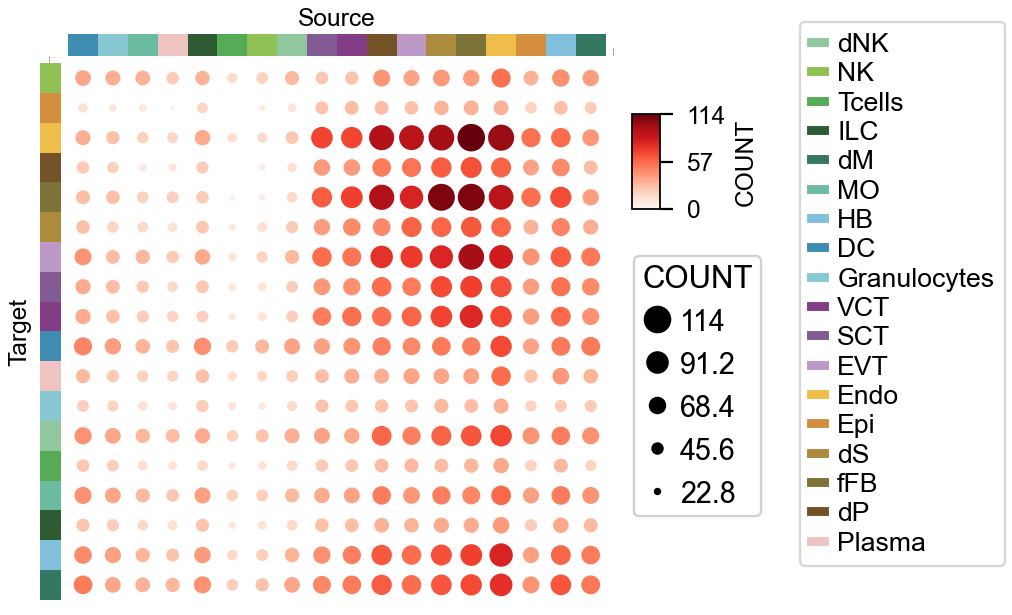

In [222]:
ov.plot_set()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_heatmap(adata,interaction['interaction_edges'],celltype_key='celltype',
                   fontsize=11,
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

plt.savefig(f'figures/cpdb/cpdb-heatmap-44.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/cpdb-heatmap-44.pdf',dpi=300,bbox_inches='tight')


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 73.92958760519767
Plotting legends..
Estimated legend width: 14.465277777777779 mm
Incresing ncol


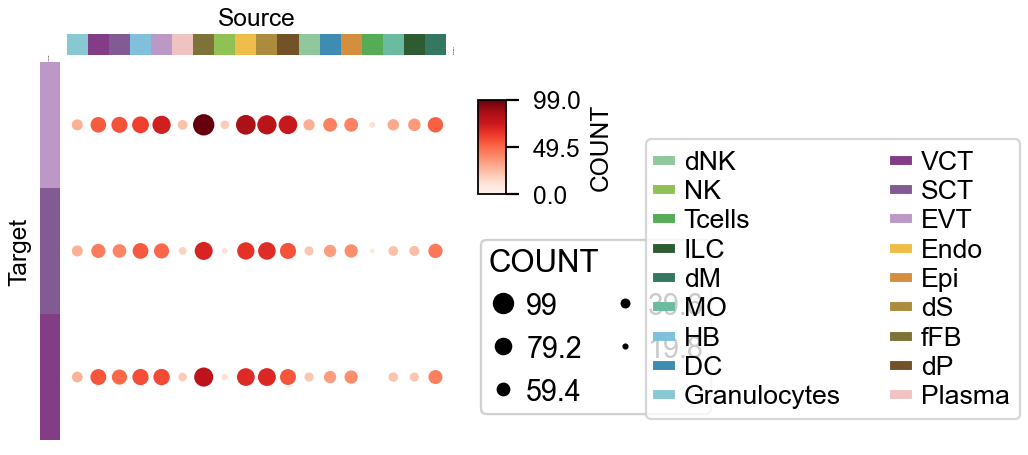

In [236]:
fig, ax = plt.subplots(figsize=(3,3)) 
ov.pl.cpdb_heatmap(adata,interaction['interaction_edges'],celltype_key='celltype',
                   target_cells=['EVT','VCT','SCT'],
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left','ncols':2})
plt.savefig(f'figures/cpdb/cpdb-heatmap-target-44.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/cpdb-heatmap-target-44.pdf',dpi=300,bbox_inches='tight')


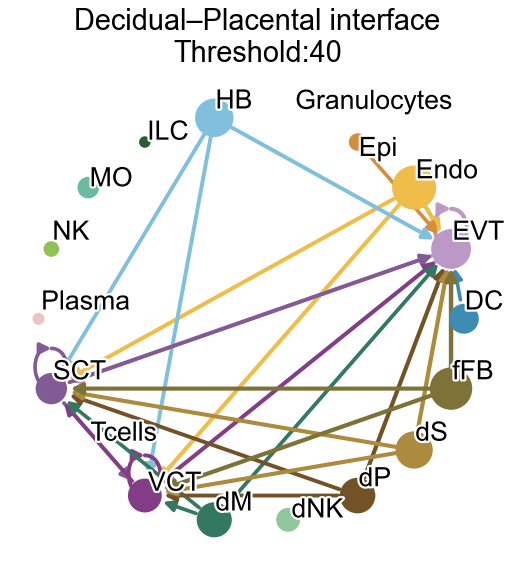

In [243]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata,interaction['interaction_edges'],celltype_key='celltype',
            counts_min=40,
            nodesize_scale=5,
            target_cells=['EVT','VCT','SCT'],
            ax=ax)
plt.title('Decidual–Placental interface\nThreshold:40',fontsize=13)
plt.savefig(f'figures/cpdb/cpdb-network-target-44.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/cpdb-network-target-44.pdf',dpi=300,bbox_inches='tight')


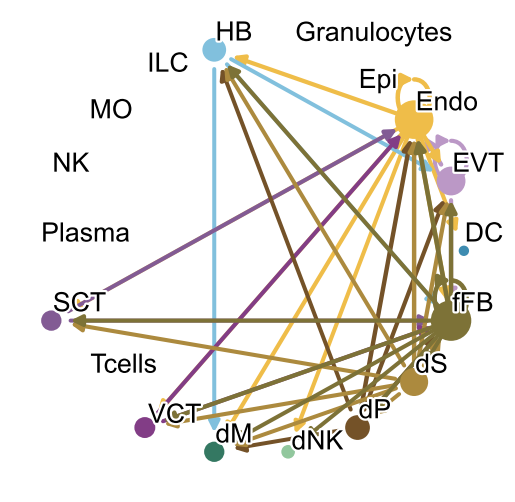

In [223]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata,interaction['interaction_edges'],celltype_key='celltype',
             counts_min=60,
            nodesize_scale=5,
                  ax=ax)
plt.savefig(f'figures/cpdb/cpdb-network-44.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/cpdb-network-44.pdf',dpi=300,bbox_inches='tight')


In [33]:
other=list(set(adata.obs['celltype'].cat.categories)-set(['EVT','SCT','VCT']))

In [125]:
target_dict={}
target_dict_whole={}
for c in other:
    sub_means=ov.single.cpdb_exact_target(cpdb_results['means'],['EVT','SCT','EVT'])
    sub_means=ov.single.cpdb_exact_source(sub_means,[c])
    sub_means=sub_means.loc[~sub_means['gene_b'].isnull()]
    sub_means=sub_means.loc[~sub_means['gene_a'].isnull()]
    test=sub_means.iloc[:,10:]
    test.index=sub_means['gene_b']
    target_dict[c]=list(set(test.sum(axis=1)[test.mean(axis=1)>1].index))

    test.index=sub_means['interacting_pair']
    target_dict_whole[c]=list(set(test.sum(axis=1)[test.mean(axis=1)>1].index))
    
    

In [127]:
[i for i in target_dict_whole['dM'] if 'TNFRSF1B' in i]

['TNF_TNFRSF1B']

In [35]:
target_dict1=target_dict.copy()
for c in other:
    all_receptor=[]
    for j in other:
        if j==c:
            continue
        all_receptor+=target_dict[j]
        all_receptor=list(set(all_receptor))
    target_dict1[c]=list(set(target_dict1[c]) - set(all_receptor))

In [36]:
target_dict1

{'Epi': ['SLC22A17', 'STRA6'],
 'MO': [],
 'dNK': ['PLXNB1'],
 'dP': ['GJC1', 'VASN'],
 'ILC': ['CCR6'],
 'Endo': ['JAML',
  'CDH5',
  'VLDLR',
  'EPHA4',
  'ACKR4',
  'ADORA3',
  'GLG1',
  'EPHA7',
  'EPHA3',
  'TEK',
  'CD200R1',
  'EPHA2',
  'EPHA1',
  'FLT4'],
 'dS': ['FGFR2', 'C3AR1', 'C5AR2'],
 'Tcells': [],
 'Granulocytes': [],
 'DC': ['PLXND1'],
 'fFB': ['LGR5', 'MET', 'ROBO2', 'ROBO1', 'NOTCH1', 'NOTCH4', 'LGR6'],
 'dM': ['TNFRSF1B'],
 'NK': [],
 'Plasma': ['NTRK3', 'VIPR1', 'VIPR2'],
 'HB': ['TFRC', 'TREML2']}

In [37]:
adata.obs=adata.obs[adata.obs.columns[~adata.obs.columns.isin([i for i in adata.obs if '_aucell' in i])]]

In [38]:
##Assest test geneset
from tqdm import trange,tqdm

with tqdm(other) as t:
    for c in t:
        #cell_n=['CLP',  'HMP', 'Mono', 'cDC', 'pDC', 'DCPre'][a]
        ret_gene=list(set(adata.var_names) & set(target_dict1[c]))
        if len(ret_gene)==0:
            continue
        print(c,len(ret_gene))
        ov.single.geneset_aucell(adata,
                            geneset_name=c+'_cellphone',
                            geneset=ret_gene)
        t.set_description('Now calculating celltype for {}'.format(c))


  0%|          | 0/15 [00:00<?, ?it/s]

Epi 2
ctxcore have been install version: 0.2.0


Now calculating celltype for Epi:   7%|▋         | 1/15 [00:42<09:53, 42.40s/it]

dNK 1
ctxcore have been install version: 0.2.0


Now calculating celltype for dNK:  20%|██        | 3/15 [01:25<05:22, 26.85s/it]

dP 2
ctxcore have been install version: 0.2.0


Now calculating celltype for dP:  27%|██▋       | 4/15 [02:07<05:54, 32.19s/it] 

ILC 1
ctxcore have been install version: 0.2.0


Now calculating celltype for ILC:  33%|███▎      | 5/15 [02:49<05:53, 35.32s/it]

Endo 14
ctxcore have been install version: 0.2.0


Now calculating celltype for Endo:  40%|████      | 6/15 [03:30<05:36, 37.34s/it]

dS 3
ctxcore have been install version: 0.2.0


Now calculating celltype for dS:  47%|████▋     | 7/15 [04:12<05:10, 38.84s/it]  

DC 1
ctxcore have been install version: 0.2.0


Now calculating celltype for DC:  67%|██████▋   | 10/15 [04:56<02:04, 24.84s/it]

fFB 7
ctxcore have been install version: 0.2.0


Now calculating celltype for fFB:  73%|███████▎  | 11/15 [05:40<01:55, 28.94s/it]

dM 1
ctxcore have been install version: 0.2.0


Now calculating celltype for dM:  80%|████████  | 12/15 [06:23<01:36, 32.33s/it] 

Plasma 3
ctxcore have been install version: 0.2.0


Now calculating celltype for Plasma:  93%|█████████▎| 14/15 [07:06<00:27, 27.91s/it]

HB 2
ctxcore have been install version: 0.2.0


Now calculating celltype for HB: 100%|██████████| 15/15 [07:48<00:00, 31.23s/it]    


In [40]:
adata

AnnData object with n_obs × n_vars = 30000 × 21002
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'celltype', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'DC_cellphone_aucell', 'fFB_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet'
    obsm: 'X_mde_pca', 'scaled|original|X_pca'

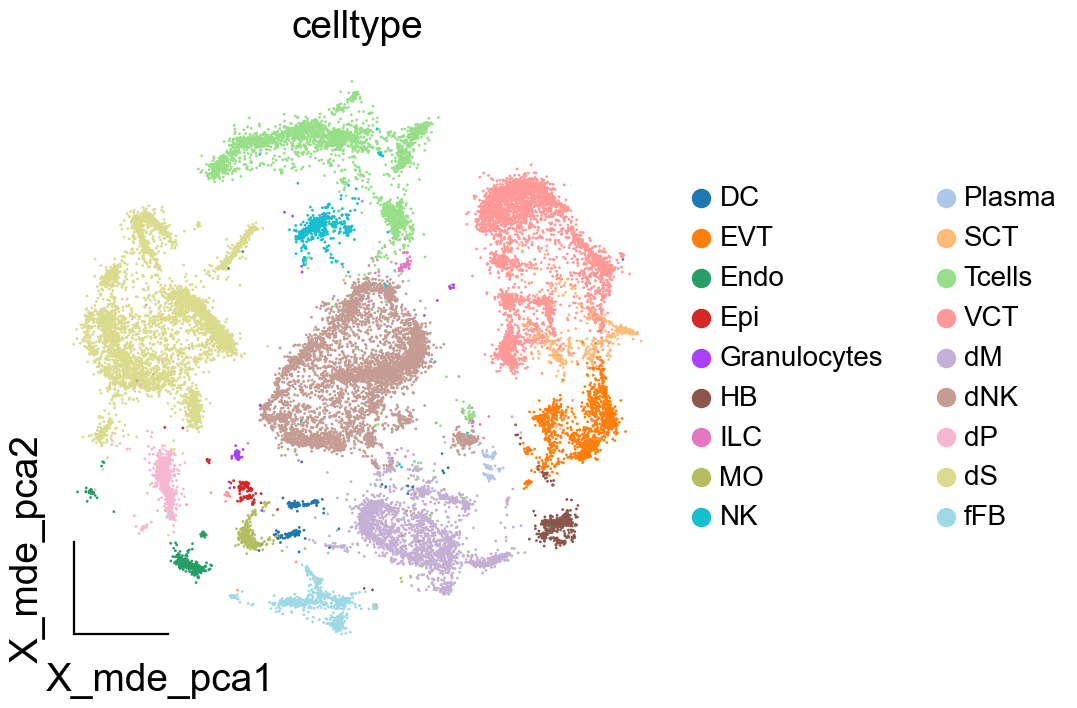

In [43]:
ov.utils.embedding(adata,
                basis='X_mde_pca',
                color='celltype',
                frameon='small')

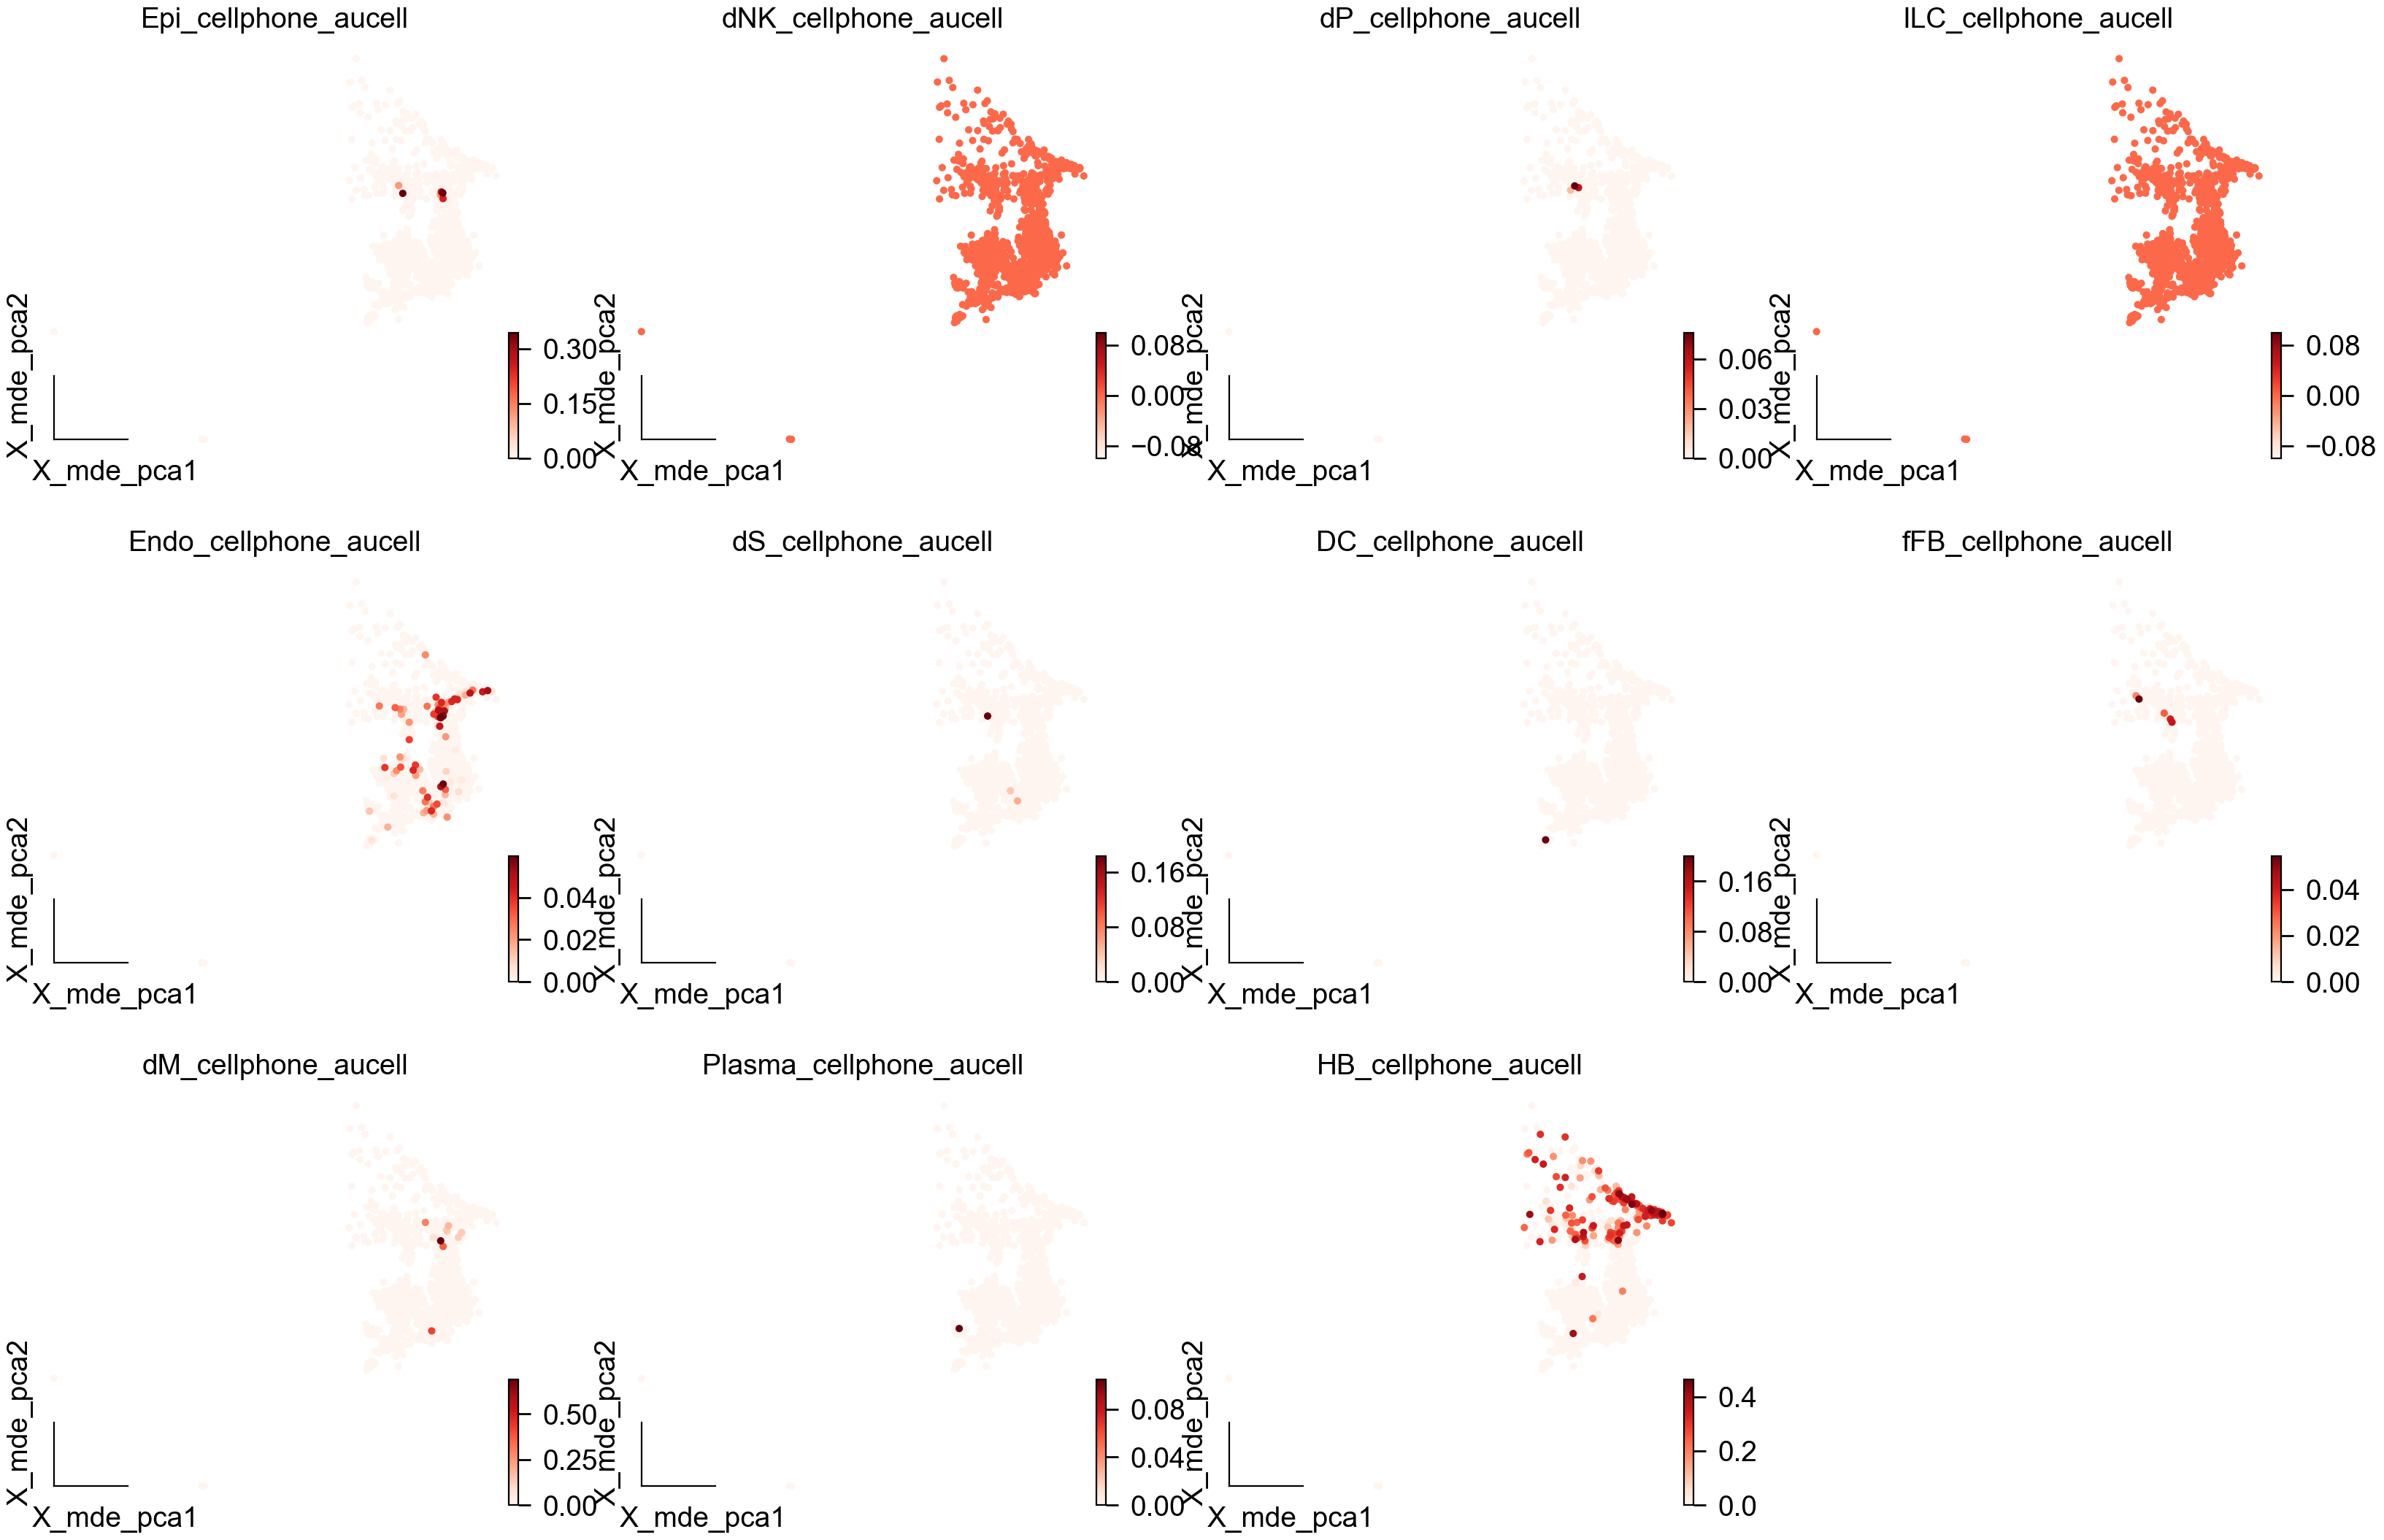

In [41]:
ov.utils.embedding(adata[adata.obs['celltype'].isin(['EVT','SCT','EVT'])],
                basis='X_mde_pca',
               color=[c+'_cellphone_aucell' for c in other if len(target_dict1[c])>0],
               frameon='small',
               cmap='Reds')

In [70]:
import pickle
with open('data/placenta/inter_gene.pth', 'wb') as f:
    pickle.dump(inter_gene, f)

In [118]:
import pickle
with open('data/placenta/inter_gene.pth', 'rb') as f:
    inter_gene = pickle.load(f)

In [119]:
max_len_inter_gene=max([len(i) for i in inter_gene.values()])
max_len_inter_gene

241

In [73]:
inter_gene_pd=pd.DataFrame(index=range(max_len_inter_gene))
for i in inter_gene.keys():
    goal_inter_gene=[]
    goal_inter_gene+=inter_gene[i]
    while len(goal_inter_gene)!=max_len_inter_gene:
        goal_inter_gene+=['']
    inter_gene_pd[i]=goal_inter_gene

In [74]:
inter_gene_pd.to_excel('data/placenta/ligand_receptor.xlsx')

In [75]:
inter_gene_pd.head()

DC                      EVT  \
0                     CCL3-CCR1                ESAM-ESAM   
1                  CXCL16-CXCR6                CCL3-CCR1   
2                  TNF-TNFRSF1B             KISS1-KISS1R   
3                     EREG-EGFR  TGFB2-TGFbeta-receptor1   
4  SEMA7A-integrin-a1b1-complex              WNT7A-SFRP1   

                        Endo            Epi  Granulocytes                  HB  \
0                  JAG1-VASN      ESAM-ESAM     CCL3-CCR1           CCL3-CCR1   
1                LGALS9-P4HB   CXCL16-CXCR6  CXCL16-CXCR6        CXCL16-CXCR6   
2                 GAS6-TYRO3     EDN1-EDNRB     EREG-EGFR        TNF-TNFRSF1A   
3  FN1-integrin-aVb1-complex  LCN2-SLC22A17      PPIA-BSG          SIRPA-CD47   
4  Desmosterol-byDHCR7-NR1H3     VEGFA-NRP1     CCL5-CCR1  IL1RN-IL1-receptor   

            ILC                  MO            NK  \
0     CCL3-CCR1           CCL3-CCR1     CCL3-CCR1   
1  TNF-TNFRSF1B        CXCL16-CXCR6  TNFSF14-LTBR   
2  TNFSF14-LTBR          SIRPA-CD47  TNF-TNFRSF1A   
3  TNF-TNFRSF1A  IL1RN-IL1-receptor      PPIA-BSG   
4   DLL1-NOTCH2           CCL5-CCR1   NCAM1-FGFR1   

                         Plasma                                  SCT  \
0                     CCL3-CCR1                            CCL3-CCR1   
1  SEMA7A-integrin-a1b1-complex  Inhibin-ligand-A-ACVR-1A2B-receptor   
2                   LGALS9-P4HB                         KISS1-KISS1R   
3                     CCL5-CCR1                          WNT7A-SFRP1   
4                    GAS6-TYRO3                         NRXN3-CLSTN1   

                         Tcells                           VCT            dM  \
0                     CCL3-CCR1                     CCL3-CCR1     CCL3-CCR1   
1                    CCL3-ACKR2                   WNT7A-SFRP1  TNF-TNFRSF1B   
2             TNFSF10-TNFRSF10B  COL4A1-integrin-a1b1-complex  CXCL16-CXCR6   
3                    CCL4-ACKR2                  NRXN3-CLSTN1     EREG-EGFR   
4  CD40LG-integrin-a5b1-complex  COL4A2-integrin-a1b1-complex  TNF-TNFRSF1A   

            dNK                             dP                         dS  \
0     CCL3-CCR1                      ESAM-ESAM                CXCL12-DPP4   
1  TNFSF14-LTBR   COL4A1-integrin-a1b1-complex                LGALS9-P4HB   
2  TNF-TNFRSF1A  COL15A1-integrin-a1b1-complex                 GAS6-TYRO3   
3      PPIA-BSG   COL4A2-integrin-a1b1-complex                 IGF2-IGF2R   
4   NCAM1-FGFR1     FBN1-integrin-a5b1-complex  FN1-integrin-aVb1-complex   

            fFB  
0   SLIT2-ROBO1  
1     JAG1-VASN  
2  IL1RAP-PTPRF  
3    GAS6-TYRO3  
4    IGF2-IGF2R

## meta cells

In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 64666 × 3000
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'celltype'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

In [170]:
adata_hvg=adata.copy()
adata_hvg=adata_hvg[:,adata_hvg.var['highly_variable_features']]

In [171]:
ov.pp.scale(adata_hvg)
ov.pp.pca(adata_hvg,layer='scaled',n_pcs=50)

adata_hvg.obsm["X_mde_pca"] = ov.utils.mde(adata_hvg.obsm["scaled|original|X_pca"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [178]:
ov.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
ov.pp.umap(adata_hvg)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


<AxesSubplot: title={'center': 'celltype'}, xlabel='X_umap1', ylabel='X_umap2'>

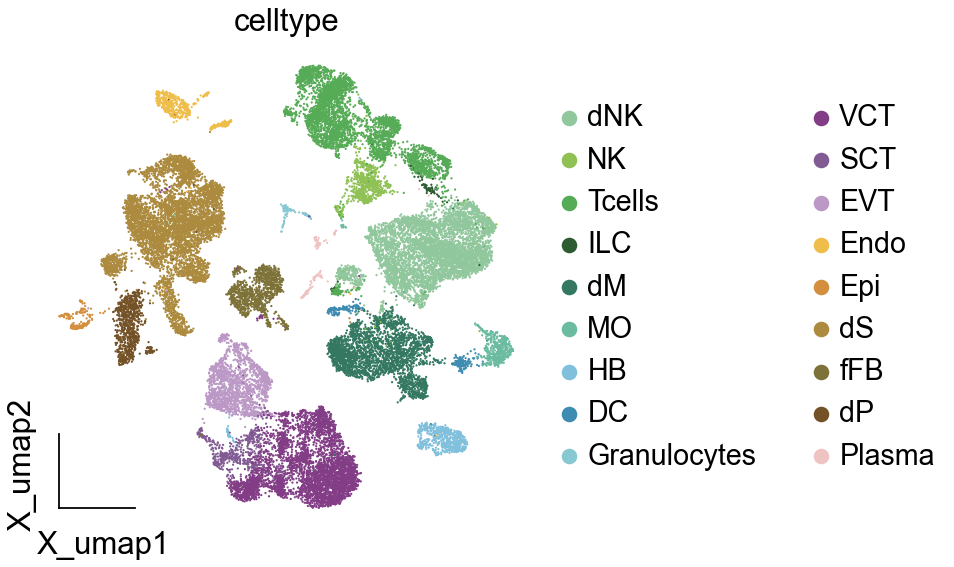

In [179]:
ov.utils.embedding(adata_hvg,
                basis='X_umap',frameon='small',
                color=['celltype'],show=False)

In [181]:
adata.obsm=adata_hvg.obsm.copy()

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>

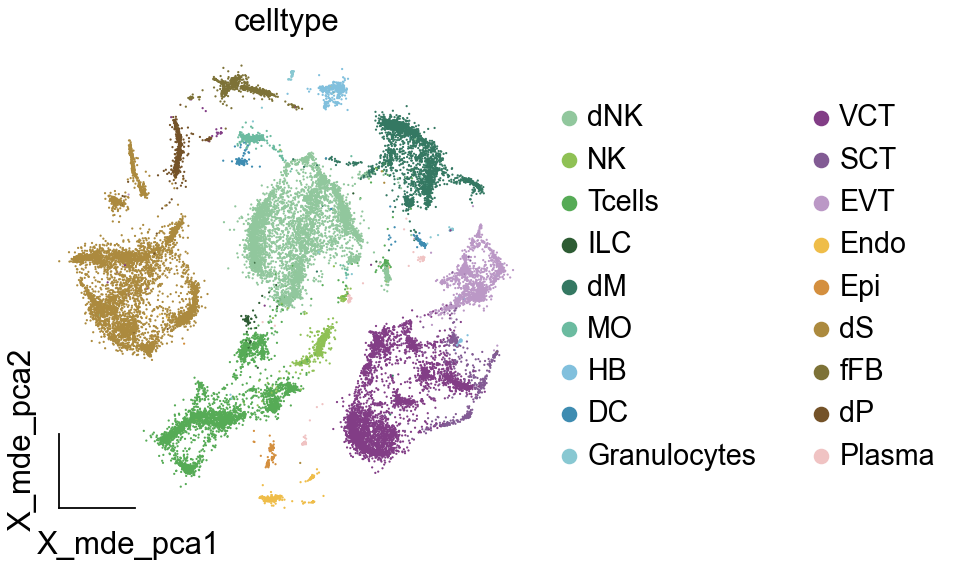

In [177]:
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['celltype'],show=False)

In [9]:
adata=adata.raw.to_adata()

In [153]:
adata.obs['celltype'].cat.categories


Index(['DC', 'EVT', 'Endo', 'Epi', 'Granulocytes', 'HB', 'ILC', 'MO', 'NK',
       'Plasma', 'SCT', 'Tcells', 'VCT', 'dM', 'dNK', 'dP', 'dS', 'fFB'],
      dtype='object')

In [158]:
new_order=['dNK','NK','Tcells','ILC','dM','MO','HB','DC','Granulocytes',
           'VCT','SCT','EVT','Endo','Epi','dS','fFB','dP','Plasma'
        ]
adata.obs['celltype']=adata.obs['celltype'].cat.reorder_categories(new_order)


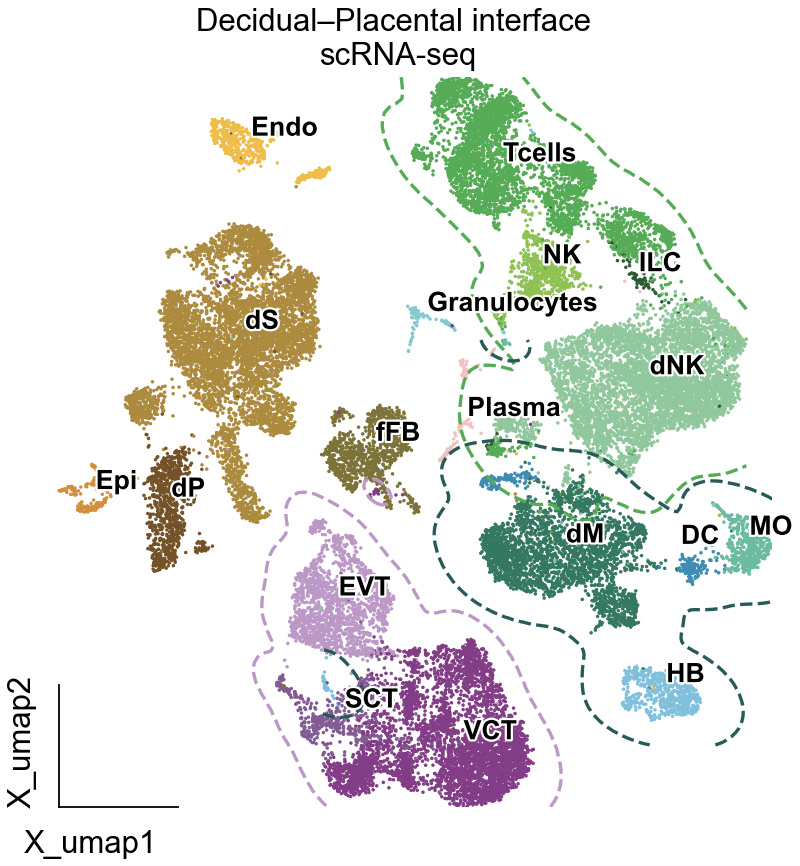

In [221]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(6,6))
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['celltype'],title='',
    show=False,  
    frameon='small',
    size=10,
    palette=ov.pl.green_color[:4]+ov.pl.blue_color[:5]+ov.pl.purple_color[:3]+ov.pl.orange_color[:5]+ov.pl.red_color[:4],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

ov.pl.embedding_adjust(
    adata,
    basis="X_umap",
    groupby='celltype',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)


ov.pl.contour(ax=ax,adata=adata,
    basis="X_umap",
              groupby='celltype',clusters=['dNK','NK','Tcells'],
        contour_threshold=0.02,colors=ov.pl.green_color[2],linestyles='dashed')



ov.pl.contour(ax=ax,adata=adata,
    basis="X_umap",
        groupby='celltype',clusters=['dM','MO','HB','DC',],
        contour_threshold=0.01,colors=ov.pl.blue_color[6],linestyles='dashed')

ov.pl.contour(ax=ax,adata=adata,
    basis="X_umap",
        groupby='celltype',clusters=['VCT','SCT','EVT',],
        contour_threshold=0.02,colors=ov.pl.purple_color[2],linestyles='dashed')

plt.title('Decidual–Placental interface \nscRNA-seq', fontsize=14)
plt.savefig(f'figures/cpdb/umap-ct-66.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/umap-ct-66.pdf',dpi=300,bbox_inches='tight')



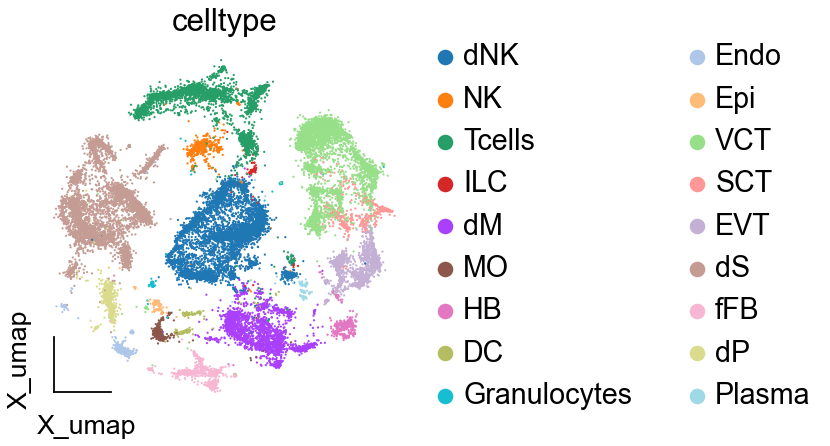

In [155]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['celltype'],show=False,ax=ax)
plt.xlabel('X_umap',loc='left',fontsize=12)
plt.ylabel('X_umap',loc='bottom',fontsize=12)
fig.savefig("figures/cpdb/u_umap_celltype.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/u_umap_celltype.pdf",dpi=300,bbox_inches = 'tight')


In [ ]:
adata.shape[0]//75

In [8]:
adata.var_names_make_unique()

In [10]:
import random
cell_idx=random.sample(adata.obs.index.tolist(),30000)
adata=adata[cell_idx]
adata

View of AnnData object with n_obs × n_vars = 30000 × 21002
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'celltype'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet'
    obsm: 'X_mde_pca', 'scaled|original|X_pca'

In [11]:
adata.write_h5ad('data/placenta/adata_preprocess.h5ad',compression='gzip')

In [1]:
import scanpy as sc
adata=sc.read('data/placenta/adata_preprocess.h5ad')

In [5]:
from SEACells.core import SEACells
model = SEACells(adata, 
                  build_kernel_on='scaled|original|X_pca', 
                  n_SEACells=500, 
                  n_waypoint_eigs=10,
                  convergence_epsilon = 1e-5,
                  #use_gpu=True,
                  #use_sparse=False
                )

Welcome to SEACells!


In [7]:
model.construct_kernel_matrix()
M = model.kernel_matrix
# Initialize archetypes
model.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/30000 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/30000 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/30000 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on scaled|original|X_pca
Computing diffusion components from scaled|original|X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
Done.
Sampling waypoints ...
Done.
Selecting 441 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 29.11it/s]

Selecting 59 cells from greedy initialization.


In [8]:
import pickle
with open('data/placenta/seacell_para' + "/model_30000.pkl", "wb") as f:
    pickle.dump(model, f)


In [2]:
import pickle
with open('data/placenta/seacell_para' + "/model_30000.pkl", 'rb') as f:
    model = pickle.load(f)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [9]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00307
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 44 iterations.


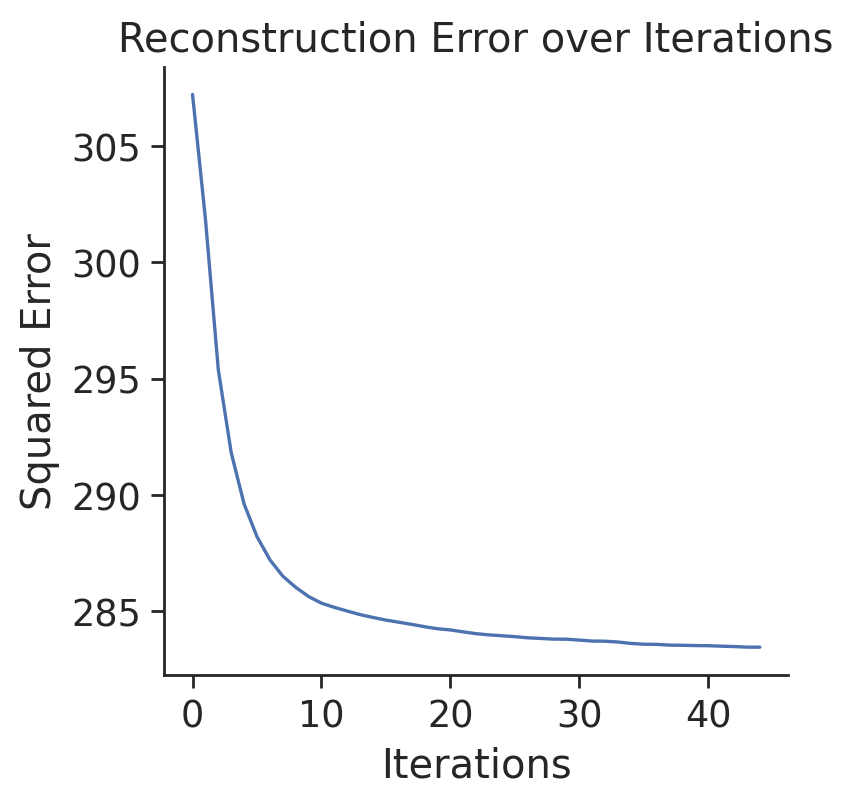

In [10]:
# Check for convergence 
%matplotlib inline
model.plot_convergence()

In [ ]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Run for {len(model.RSS_iters)} iterations')
for _ in range(10):
    model.step()
print(f'Run for {len(model.RSS_iters)} iterations')

In [ ]:
# Check for convergence 
%matplotlib inline
model.plot_convergence()

In [6]:
model.save_assignments('data/placenta/seacell_para')
#model.save_model('data/placenta/seacell_para')

In [ ]:
from scipy import io
outdir='data/placenta/seacell_para'
model.kernel_matrix = io.loadmat(outdir + "/kernel_matrix.npz")
model.A_.T=io.loadmat(outdir + "/A.npz")
model.B_=io.loadmat(outdir + "/B.npz")


In [11]:
adata.write_h5ad('data/placenta/adata_seacells.h5ad',compression='gzip')

In [44]:
import scanpy as sc
ad=sc.read('data/placenta/adata_seacells.h5ad',compression='gzip')

In [121]:
import pickle
with open('data/placenta/seacell_para' + "/model_30000.pkl", "wb") as f:
    pickle.dump(model, f)


In [3]:
outdir='data/placenta/seacell_para'
import pickle
with open(outdir + "/model_30000.pkl", 'rb') as f:
    model = pickle.load(f)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


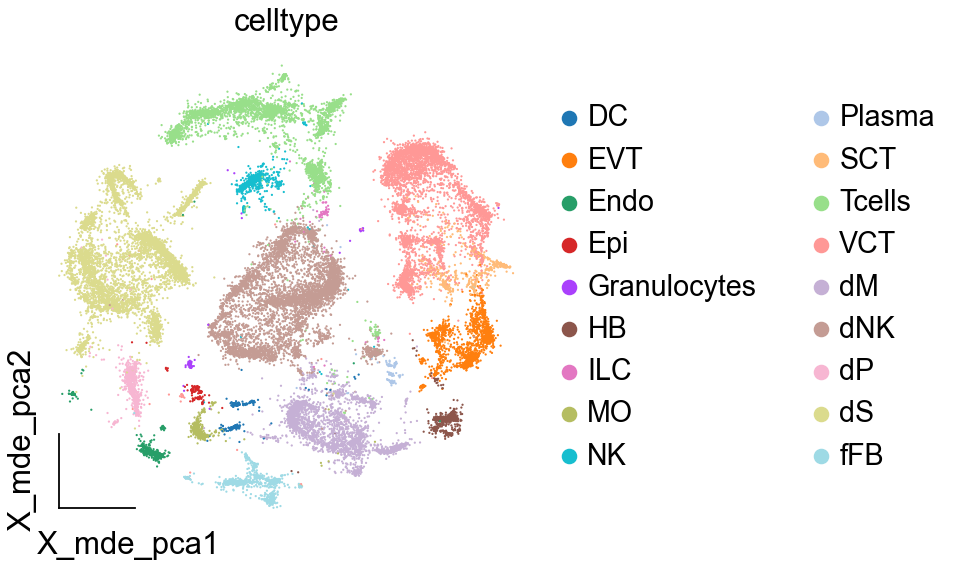

In [150]:
ov.utils.embedding(adata,
                basis='X_mde_pca',
                color='celltype',
                frameon='small')

In [ ]:
%matplotlib inline
from SEACells.plot import plot_2D
plot_2D(adata, key='X_mde_pca', colour_metacells=False,
                     figsize=(4,4),cell_size=20,title='Metacells',
                     save_as='figures/fig4/metacell.png')
plot_2D(adata, key='X_mde_pca', colour_metacells=False,
                     figsize=(4,4),cell_size=20,title='Metacells',
                     save_as='pdf/fig4/metacell.pdf')

In [4]:
adata.raw=adata.copy()

In [14]:
adata.layers['normlog']=adata.X.copy()

In [ ]:
from SEACells.core import summarize_by_soft_SEACell
SEACell_soft_ad = summarize_by_soft_SEACell(adata, model.A_, 
                                                          celltype_label='celltype',
                                                          summarize_layer='normlog', minimum_weight=0.05)
SEACell_soft_ad

 39%|████████████████████████████████████▎                                                         | 193/500 [08:40<13:48,  2.70s/it]

In [14]:
from SEACells.core import sparsify_assignments
A=sparsify_assignments(model.A_.T, thresh=0.05)

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/SEACells/core.py:114: RuntimeWarning: invalid value encountered in divide
  A = A / A.sum(1, keepdims=True)


In [17]:
SEACell_soft_ad.X.max()

11.884918546110386

In [20]:
SEACell_soft_ad.write_h5ad('data/placenta/adata_SEACell_soft_ad.h5ad',compression='gzip')

In [21]:
import scanpy as sc
SEACell_soft_ad.raw=SEACell_soft_ad.copy()
sc.pp.highly_variable_genes(SEACell_soft_ad, n_top_genes=2000, inplace=True)
SEACell_soft_ad=SEACell_soft_ad[:,SEACell_soft_ad.var.highly_variable]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [22]:
ov.pp.scale(SEACell_soft_ad)
ov.pp.pca(SEACell_soft_ad,layer='scaled',n_pcs=50)
sc.pp.neighbors(SEACell_soft_ad, use_rep='scaled|original|X_pca')
sc.tl.umap(SEACell_soft_ad)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [186]:
SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].astype('category')
SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].cat.reorder_categories(adata.obs['celltype'].cat.categories)
SEACell_soft_ad.uns['celltype_colors']=adata.uns['celltype_colors']

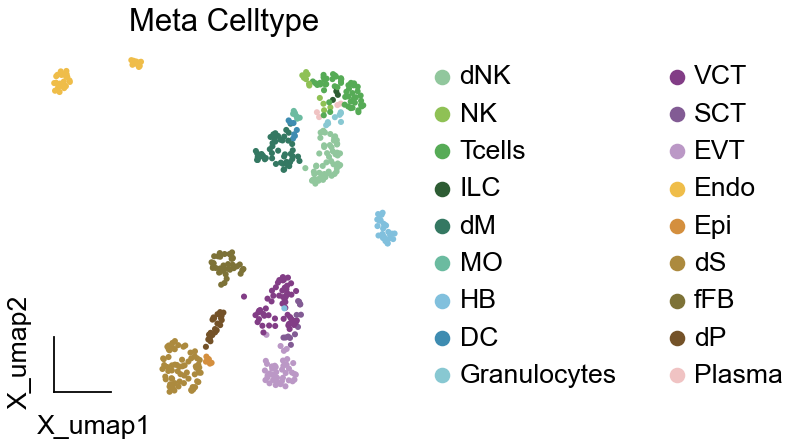

In [187]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(SEACell_soft_ad,
                   basis='X_umap',
                   color=["celltype"],
                   title='Meta Celltype',
                   frameon='small',
                   legend_fontsize=12,
                   size=30,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   show=False)
fig.savefig("figures/cpdb/u_umap_ct_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/u_umap_ct_meta.pdf",dpi=300,bbox_inches = 'tight')


In [25]:
SEACell_soft_ad.write_h5ad('data/placenta/adata_SEACell_soft_hvg.h5ad',compression='gzip')

In [45]:
SEACell_soft_ad=sc.read('data/placenta/adata_SEACell_soft_hvg.h5ad')

In [46]:
SEACell_soft_ad.obs=SEACell_soft_ad.obs[SEACell_soft_ad.obs.columns[~SEACell_soft_ad.obs.columns.isin([i for i in SEACell_soft_ad.obs if '_aucell' in i])]]

In [54]:
SEACell_soft_ad=SEACell_soft_ad.raw.to_adata()

In [55]:
##Assest test geneset
from tqdm import trange,tqdm

with tqdm(other) as t:
    for c in t:
        #cell_n=['CLP',  'HMP', 'Mono', 'cDC', 'pDC', 'DCPre'][a]
        ret_gene=list(set(SEACell_soft_ad.var_names) & set(target_dict1[c]))
        if len(ret_gene)==0:
            continue
        print(c,len(ret_gene))
        ov.single.geneset_aucell(SEACell_soft_ad,
                            geneset_name=c+'_cellphone',
                            geneset=ret_gene)
        t.set_description('Now calculating celltype for {}'.format(c))


  0%|          | 0/15 [00:00<?, ?it/s]

Epi 2
ctxcore have been install version: 0.2.0


Now calculating celltype for Epi:   7%|▋         | 1/15 [00:00<00:12,  1.08it/s]

dNK 1
ctxcore have been install version: 0.2.0


Now calculating celltype for dNK:  20%|██        | 3/15 [00:01<00:06,  1.73it/s]

dP 2
ctxcore have been install version: 0.2.0


Now calculating celltype for dP:  27%|██▋       | 4/15 [00:02<00:07,  1.44it/s] 

ILC 1
ctxcore have been install version: 0.2.0


Now calculating celltype for ILC:  33%|███▎      | 5/15 [00:03<00:07,  1.31it/s]

Endo 14
ctxcore have been install version: 0.2.0


Now calculating celltype for Endo:  40%|████      | 6/15 [00:04<00:07,  1.23it/s]

dS 3
ctxcore have been install version: 0.2.0


Now calculating celltype for dS:  47%|████▋     | 7/15 [00:05<00:06,  1.19it/s]  

DC 1
ctxcore have been install version: 0.2.0


Now calculating celltype for DC:  67%|██████▋   | 10/15 [00:06<00:02,  1.88it/s]

fFB 7
ctxcore have been install version: 0.2.0


Now calculating celltype for fFB:  73%|███████▎  | 11/15 [00:07<00:02,  1.63it/s]

dM 1
ctxcore have been install version: 0.2.0


Now calculating celltype for dM:  80%|████████  | 12/15 [00:08<00:02,  1.46it/s] 

Plasma 3
ctxcore have been install version: 0.2.0


Now calculating celltype for Plasma:  93%|█████████▎| 14/15 [00:09<00:00,  1.69it/s]

HB 2
ctxcore have been install version: 0.2.0


Now calculating celltype for HB: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]    


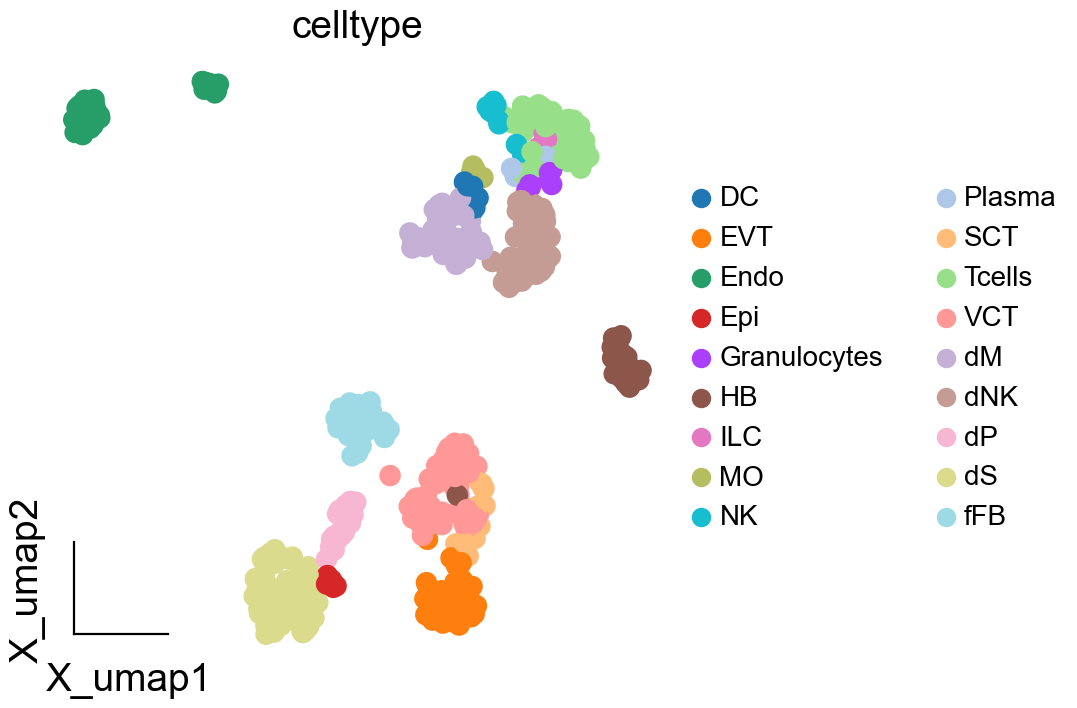

In [56]:
ov.utils.embedding(SEACell_soft_ad,
                basis='X_umap',
                color='celltype',
                frameon='small')

In [57]:
SEACell_soft_ad

AnnData object with n_obs × n_vars = 500 × 21002
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'fFB_cellphone_aucell', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'DC_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_umap', 'scaled|original|X_pca'
    obsp: 'connectivities', 'distances'

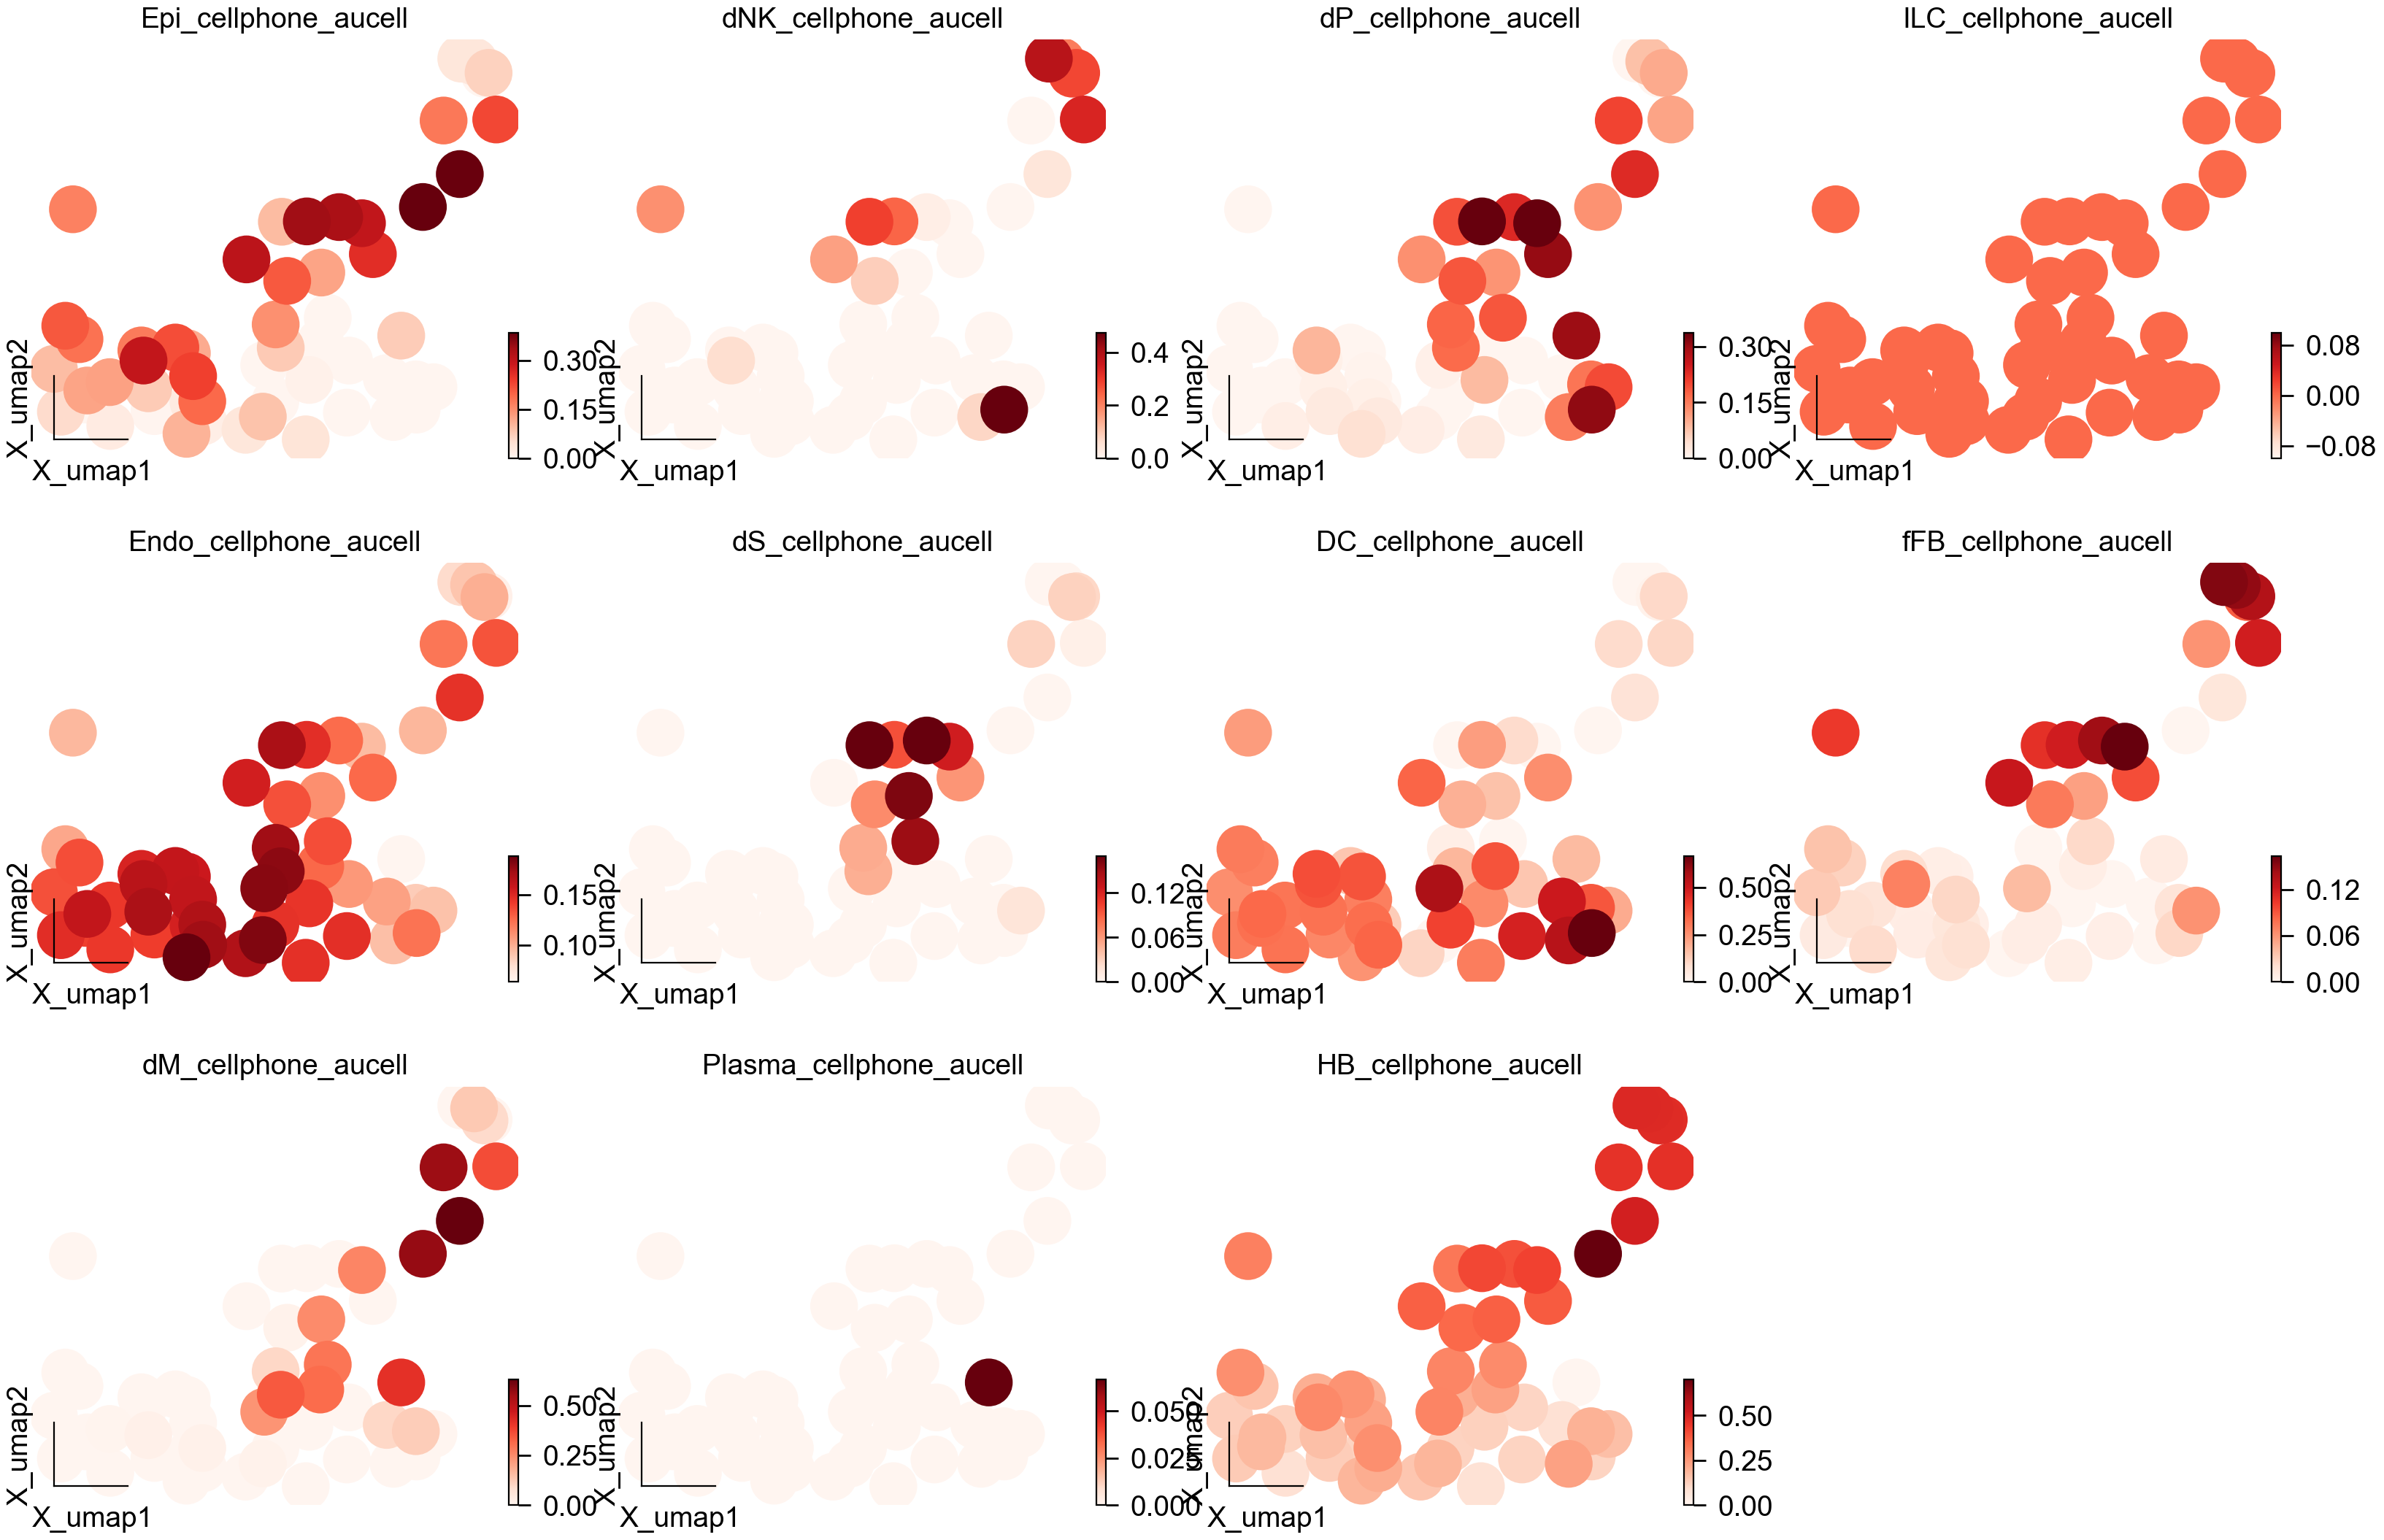

In [58]:
ov.utils.embedding(SEACell_soft_ad[SEACell_soft_ad.obs['celltype'].isin(['EVT','SCT','EVT'])],
                basis='X_umap',
               color=[c+'_cellphone_aucell' for c in other if len(target_dict1[c])>0],
               frameon='small',
               cmap='Reds')

In [198]:
SEACell_soft_ad

AnnData object with n_obs × n_vars = 500 × 21002
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'fFB_cellphone_aucell', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'DC_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell', 'pt_via'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_umap', 'scaled|original|X_pca'
    obsp: 'connectivities', 'distances'

## Trajectory

In [60]:
v0 = ov.single.pyVIA(adata=SEACell_soft_ad,adata_key='scaled|original|X_pca',
                         adata_ncomps=100, basis='X_umap',
                         clusters='celltype',knn=15, root_user=['VCT'],
                         #dataset='group', 
                         random_seed=42,is_coarse=True, 
                         preserve_disconnected=True,
                         piegraph_arrow_head_width=0.05,piegraph_edgeweight_scalingfactor=2.5,
                         gene_matrix=adata.X,velo_weight=0.5,
                         edgebundle_pruning_twice=False, edgebundle_pruning=0.15, 
                         jac_std_global=0.01,too_big_factor=0.1,
                         cluster_graph_pruning_std=0.1,
                         time_series=False,
                        )

v0.run()

2024-07-04 16:15:14.192555	Running VIA over input data of 500 (samples) x 50 (features)
2024-07-04 16:15:14.192747	Knngraph has 15 neighbors
2024-07-04 16:15:14.453722	Finished global pruning of 15-knn graph used for clustering at level of 0.01. Kept 47.8 % of edges. 
2024-07-04 16:15:14.469264	Number of connected components used for clustergraph  is 1
2024-07-04 16:15:14.476777	Commencing community detection
2024-07-04 16:15:14.493208	Finished running Leiden algorithm. Found 66 clusters.
2024-07-04 16:15:14.493601	Merging 46 very small clusters (<10)
2024-07-04 16:15:14.494119	Finished detecting communities. Found 20 communities
2024-07-04 16:15:14.494165	Making cluster graph. Global cluster graph pruning level: 0.1
2024-07-04 16:15:14.495862	Graph has 1 connected components before pruning
2024-07-04 16:15:14.497220	Graph has 8 connected components after pruning
2024-07-04 16:15:14.506348	Graph has 1 connected components after reconnecting
2024-07-04 16:15:14.506836	0.0% links trimmed

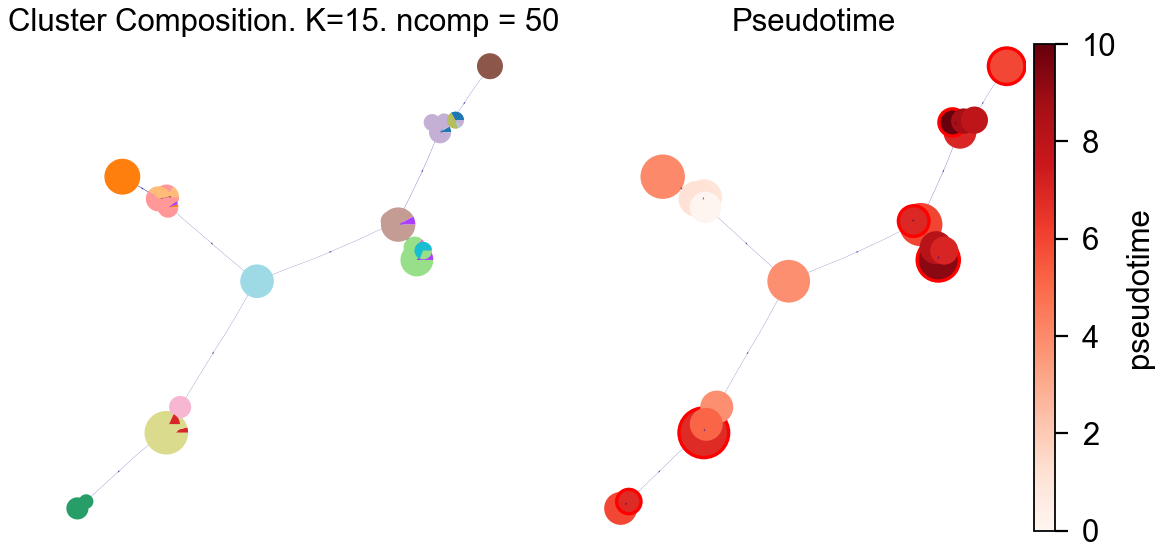

In [61]:
fig, ax, ax1 = v0.plot_piechart_graph(clusters='celltype',cmap='Reds',dpi=80,
                                   show_legend=False,ax_text=False,fontsize=4)
fig.savefig("figures/fig4/pyvia_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/fig4/pyvia_meta.pdf",dpi=300,bbox_inches = 'tight')


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2023-09-13 13:13:00.522851	Super cluster 0 is a super terminal with sub_terminal cluster 0
2023-09-13 13:13:00.522992	Super cluster 4 is a super terminal with sub_terminal cluster 4
2023-09-13 13:13:00.523010	Super cluster 5 is a super terminal with sub_terminal cluster 5
2023-09-13 13:13:00.523026	Super cluster 9 is a super terminal with sub_terminal cluster 9
2023-09-13 13:13:00.523043	Super cluster 16 is a super terminal with sub_terminal cluster 16
2023-09-13 13:13:00.523057	Super cluster 18 is a super terminal with sub_terminal cluster 18


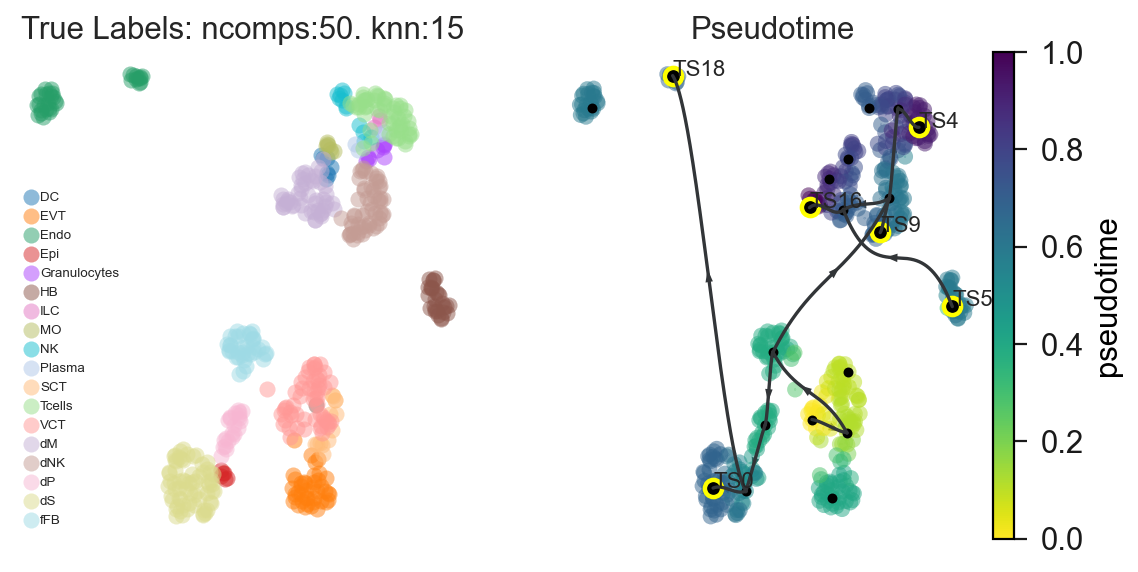

In [61]:
fig,ax1,ax2=v0.plot_trajectory_gams(basis='X_umap',clusters='celltype',draw_all_curves=False)
fig.savefig("figures/fig4/pyvia_meta_time.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/fig4/pyvia_meta_time.pdf",dpi=300,bbox_inches = 'tight')


In [62]:
v0.get_pseudotime(SEACell_soft_ad)
SEACell_soft_ad

...the pseudotime of VIA added to AnnData obs named `pt_via`


AnnData object with n_obs × n_vars = 500 × 21002
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'fFB_cellphone_aucell', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'DC_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell', 'pt_via'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_umap', 'scaled|original|X_pca'
    obsp: 'connectivities', 'distances'

In [63]:
cp_ad=sc.AnnData(SEACell_soft_ad.obs[[c+'_cellphone_aucell' for c in other if len(target_dict1[c])>0]],obs=SEACell_soft_ad.obs)

In [64]:
cp_ad.obs=cp_ad.obs[cp_ad.obs.columns[~cp_ad.obs.columns.str.contains('aucell')]]

In [199]:
cp_ad.obs

Pseudo-sizes celltype  celltype_purity    pt_via
0       52.804590      EVT         1.000000  0.403327
1       60.887635      SCT         0.641850  0.202587
2       49.201084       dP         0.993503  0.384033
3       80.276893   Tcells         0.990322  0.927651
4      138.237707       dS         0.989270  0.683542
..            ...      ...              ...       ...
495     58.916632   Tcells         0.996806  0.870631
496     32.531902      fFB         1.000000  0.384997
497    118.593680      dNK         0.996794  0.694023
498     39.752946       dP         1.000000  0.384033
499     82.596753      VCT         1.000000  0.116556

[500 rows x 4 columns]

In [188]:
cp_ad.uns['celltype_colors']=SEACell_soft_ad.uns['celltype_colors']
cp_ad.obsm=SEACell_soft_ad.obsm.copy()
cp_ad.obsp=SEACell_soft_ad.obsp.copy()

In [200]:
cp_ad.obs=SEACell_soft_ad.obs.copy()

[<AxesSubplot: title={'center': 'Meta Celltype'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot: title={'center': 'pt_via'}, xlabel='X_umap1', ylabel='X_umap2'>]

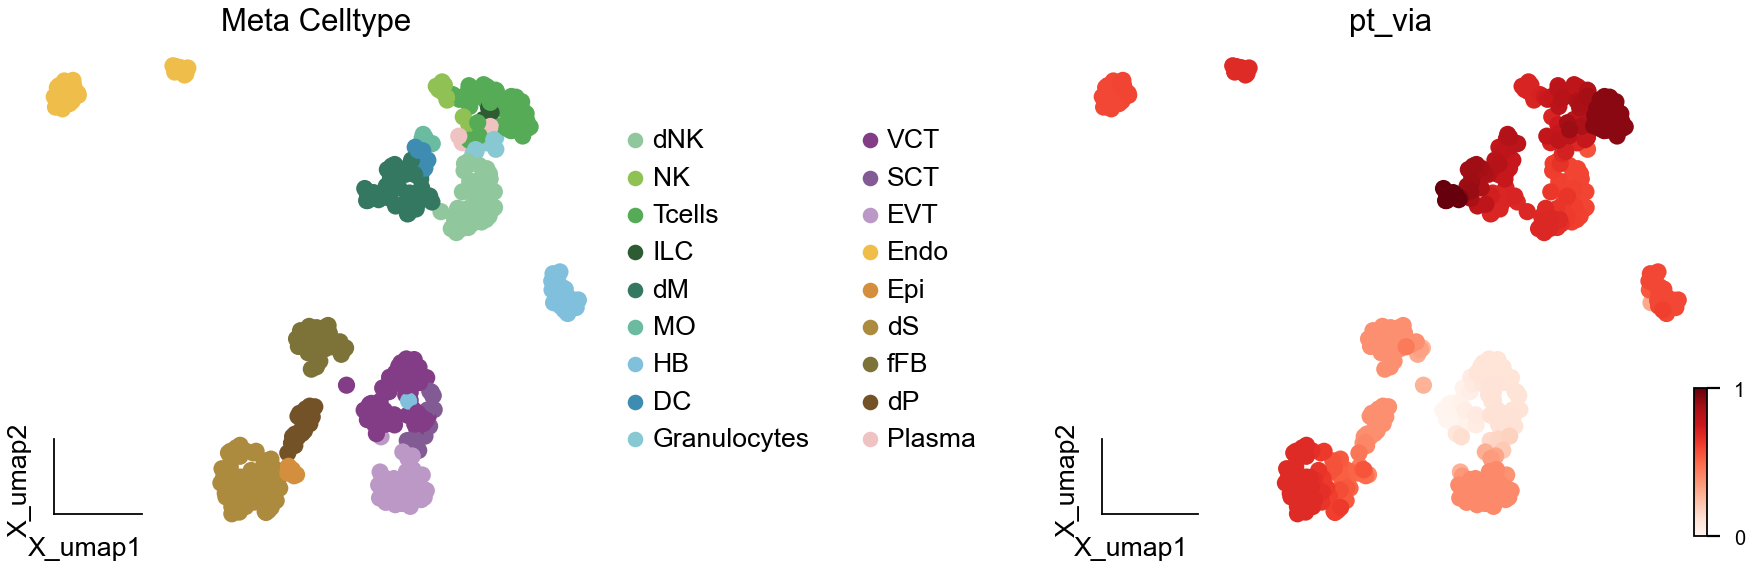

In [201]:
import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(cp_ad,
                   basis='X_umap',
                   color=["celltype","pt_via"],
                   title='Meta Celltype',
                   frameon='small',
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   #ax=ax,
                   wspace=0.65,
                   cmap='Reds',
                   show=False)

## Cellfategenie

In [202]:
adata_aucs=cp_ad[cp_ad.obs['celltype'].isin(['EVT','VCT','SCT'])]
cfg_obj=ov.single.Fate(adata_aucs,pseudotime='pt_via')
cfg_obj.model_init()

$MSE|RMSE|MAE|R^2$:0.0058|0.076|0.057|0.74


coef  abs(coef)    values
HB_cellphone_aucell     -0.531380   0.531380  0.330316
fFB_cellphone_aucell    -0.510062   0.510062  0.123325
Endo_cellphone_aucell    0.412996   0.412996  0.106126
dS_cellphone_aucell      0.138893   0.138893  0.051529
dP_cellphone_aucell      0.082842   0.082842  0.053625
DC_cellphone_aucell      0.074802   0.074802  0.150316
dNK_cellphone_aucell    -0.051550   0.051550  0.216962
Plasma_cellphone_aucell  0.045087   0.045087  0.002577
Epi_cellphone_aucell    -0.036684   0.036684  0.068667
dM_cellphone_aucell     -0.024617   0.024617  0.044037
ILC_cellphone_aucell     0.000000   0.000000  0.000000

In [203]:
cfg_obj.ATR(stop=10)

coef_threshold:0.5100619746793011, r2:0.7291260296213959


coef_threshold        r2
0        0.510062  0.729126
1        0.412996  0.755048
2        0.138893  0.761039
3        0.082842  0.751230
4        0.074802  0.745696
5        0.051550  0.745078
6        0.045087  0.745138
7        0.036684  0.741476
8        0.024617  0.739518
9        0.000000  0.739518

In [204]:
#如果配受体太少，那么无法自动识别最佳阈值，我们手动设定最小的使用全部配受体
cfg_obj.coef_threshold=0.001

Text(0.5, 1.0, 'Metacells\nCellFateGenie')

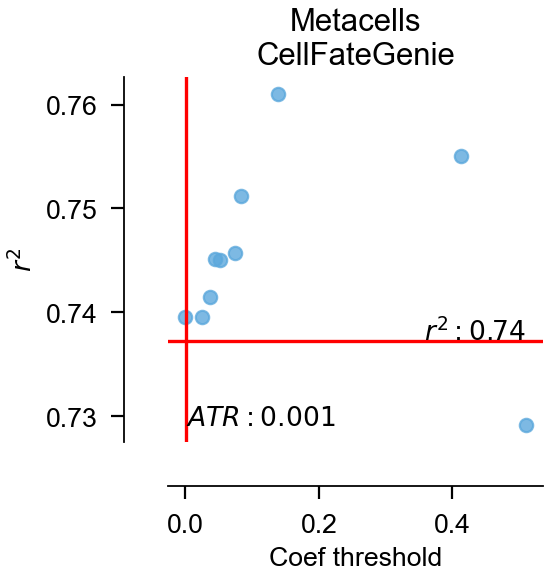

In [205]:
fig,ax=cfg_obj.plot_filtering(color='#5ca8dc')
ax.set_title('Metacells\nCellFateGenie')

In [206]:
res=cfg_obj.model_fit()

$MSE|RMSE|MAE|R^2$:0.0058|0.076|0.057|0.74


(0.0, 1.0)

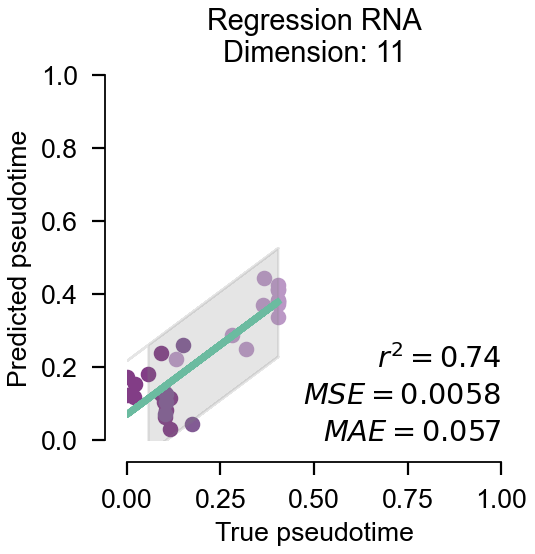

In [207]:
cfg_obj.plot_color_fitting(type='raw',cluster_key='celltype')
plt.xlim(0,1)
plt.ylim(0,1)

(0.0, 1.0)

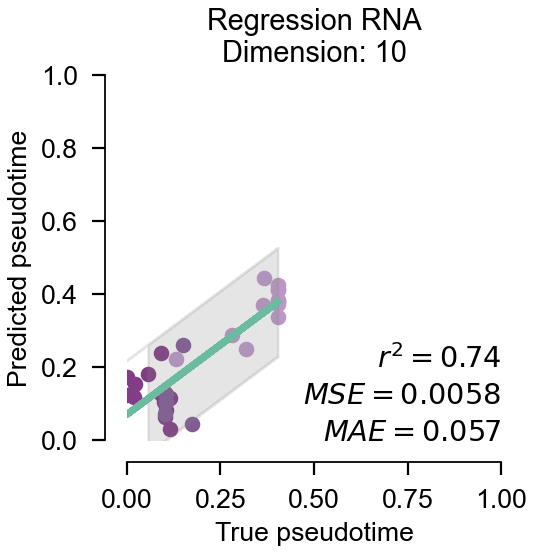

In [208]:
cfg_obj.plot_color_fitting(type='filter',cluster_key='celltype')
plt.xlim(0,1)
plt.ylim(0,1)

In [209]:
var_name=cfg_obj.filter_coef.index.tolist()

In [210]:
ov.plot_set()
adata_aucs

All dependencies are satisfied.


AnnData object with n_obs × n_vars = 110 × 11
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'fFB_cellphone_aucell', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'DC_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell', 'pt_via'
    uns: 'celltype_colors'
    obsm: 'X_umap', 'scaled|original|X_pca'
    obsp: 'connectivities', 'distances'

In [211]:
cfg_obj.low_density(pca_key='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
[2024-07-04 18:51:30,584] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (110) >= n_samples (110) and rank = 1.0.
[2024-07-04 18:51:30,585] [INFO    ] Computing nearest neighbor distances.
[2024-07-04 18:51:30,601] [INFO    ] Using d=1.9961217737773809.
[2024-07-04 18:51:30,602] [INFO    ] Using covariance function Matern52(ls=1.59648289121322).
[2024-07-04 18:51:30,607] [INFO    ] Using rank 110 covariance representation.
[2024-07-04 18:51:30,634] [INFO    ] Running inference using L-BFGS-B.


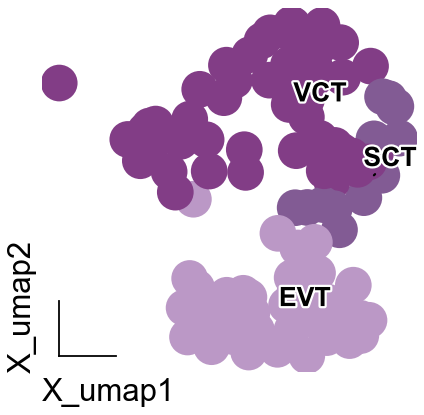

In [216]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    adata_aucs,
    basis="X_umap",
    color=['celltype'],title='',
    show=False,  
    frameon='small',
    #size=10,
    #palette=ov.pl.green_color[:4]+ov.pl.blue_color[:5]+ov.pl.purple_color[:3]+ov.pl.orange_color[:5]+ov.pl.red_color[:4],
    ax=ax,
    legend_loc=None, add_outline=False, 
)
ov.pl.embedding_adjust(
    adata_aucs,
    basis="X_umap",
    groupby='celltype',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

fig.savefig("figures/cpdb/evt_umap_ct_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/evt_umap_ct_meta.pdf",dpi=300,bbox_inches = 'tight')


In [247]:
import cellrank as cr

In [249]:
pk = cr.kernels.PseudotimeKernel(adata_aucs, time_key="pt_via")
pk.compute_transition_matrix()

print(pk)

Computing transition matrix based on pseudotime


  0%|          | 0/110 [00:00<?, ?cell/s]

    Finish (0:00:00)
PseudotimeKernel[n=110]


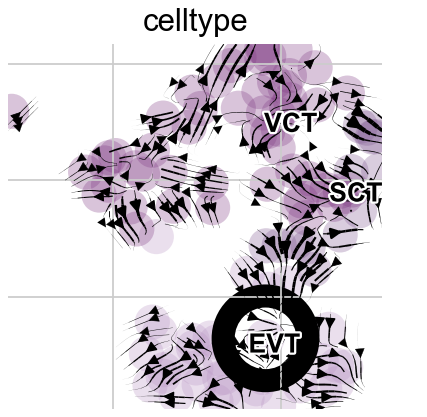

In [260]:
import scvelo as scv
fig, ax = plt.subplots(figsize=(3,3))
scv.pl.velocity_embedding_stream(adata_aucs,vkey='T_fwd', basis='umap',
                                smooth=1,min_mass=2,size=1000,
                                color='celltype',legend_loc=None, add_outline=False, 
                                show=False,ax=ax)
ov.pl.embedding_adjust(
    adata_aucs,
    basis="X_umap",
    groupby='celltype',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)



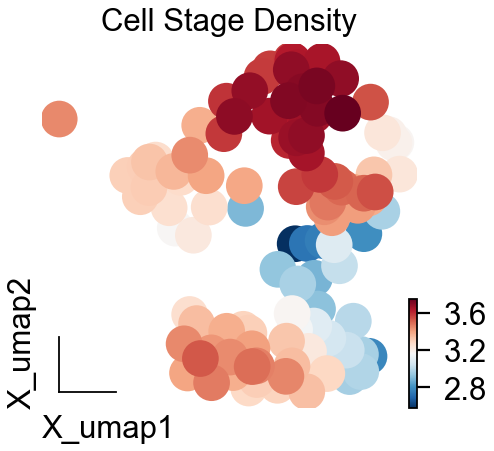

In [217]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    adata_aucs,
    basis="X_umap",
    color=['mellon_log_density_lowd'],title='Cell Stage Density',
    show=False,  
    frameon='small',
    #size=10,
    #palette=ov.pl.green_color[:4]+ov.pl.blue_color[:5]+ov.pl.purple_color[:3]+ov.pl.orange_color[:5]+ov.pl.red_color[:4],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

fig.savefig("figures/cpdb/evt_umap_density_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/evt_umap_density_meta.pdf",dpi=300,bbox_inches = 'tight')


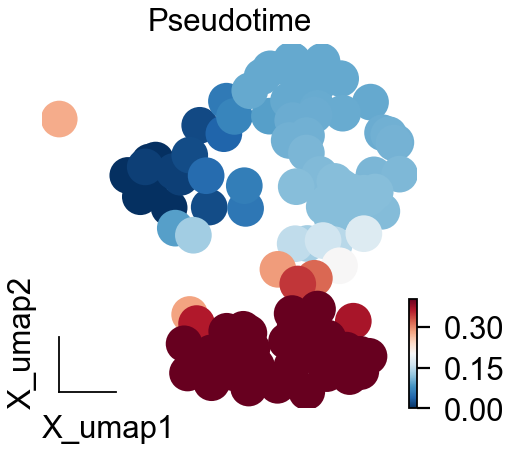

In [252]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    adata_aucs,
    basis="X_umap",
    color=['pt_via'],title='Pseudotime',
    show=False,  
    frameon='small',
    #size=10,
    #palette=ov.pl.green_color[:4]+ov.pl.blue_color[:5]+ov.pl.purple_color[:3]+ov.pl.orange_color[:5]+ov.pl.red_color[:4],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

fig.savefig("figures/cpdb/evt_umap_pt_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/evt_umap_pt_meta.pdf",dpi=300,bbox_inches = 'tight')


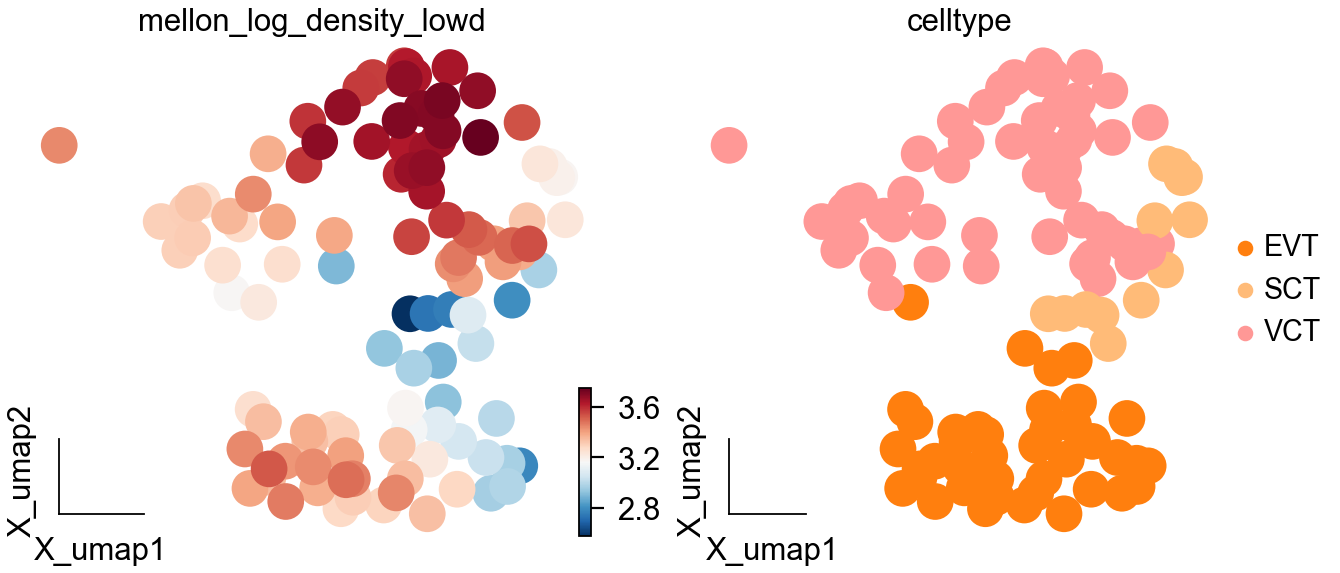

In [84]:
ov.pl.embedding(adata_aucs,
                basis='X_umap',
                color=['mellon_log_density_lowd','celltype'],
                frameon='small',
               cmap='RdBu_r')

/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/seaborn/matrix.py:1107: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


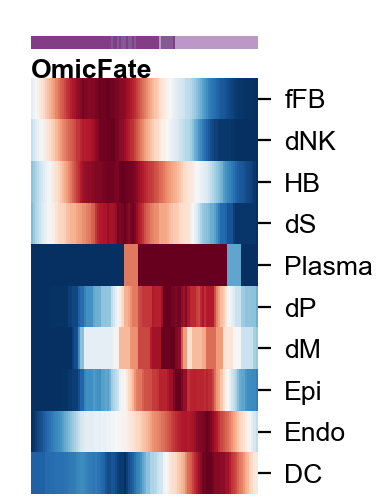

In [272]:
import matplotlib.pyplot as plt
g=ov.utils.plot_heatmap(adata_aucs,#[adata_aucs.obs['celltype'].isin(visual_cluster)],
                        var_names=var_name,
                  sortby='pt_via',col_color='celltype',
                 n_convolve=50,figsize=(1,6),show=False,)

g.fig.set_size_inches(2, 4)
g.fig.suptitle('OmicFate',x=0.25,y=0.83,
               horizontalalignment='left',fontsize=12,fontweight='bold')
g.ax_heatmap.set_yticklabels([i.get_text().split('_')[0] for i in g.ax_heatmap.get_yticklabels()],fontsize=12)

#plt.show()

plt.savefig(f'figures/cpdb/heatmap_omicfate.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/heatmap_omicfate.pdf',dpi=300,bbox_inches='tight')



/tmp/ipykernel_733398/1287681096.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/tmp/ipykernel_733398/1287681096.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


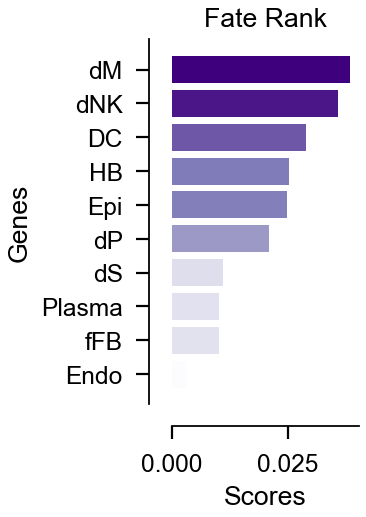

In [287]:
# 创建横向柱状图
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(1.5, 3))

od_genes=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:10]

norm = plt.Normalize(min(od_genes.values), max(od_genes.values))
colors = cm.Purples(norm(od_genes.values))

plt.barh(od_genes.index, od_genes.values, color=colors)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
#ax.set_xlim(0,0.001)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels([i.get_text().split('_')[0] for i in ax.get_yticklabels()], fontsize=11)

plt.xlabel('Scores',fontsize=12)
plt.ylabel('Genes',fontsize=12)
plt.title('Fate Rank',fontsize=12)
plt.gca().invert_yaxis()  # 反转y轴使得最高分数在顶部

plt.savefig(f'figures/cpdb/cpdb_bar_rank.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/cpdb_bar_rank.pdf',dpi=300,bbox_inches='tight')


In [118]:
ov.plot_set()

All dependencies are satisfied.


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


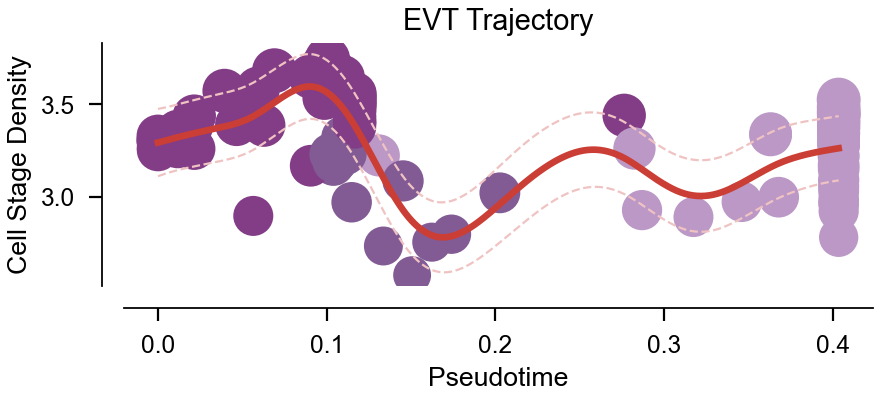

In [246]:
fig, ax = plt.subplots(figsize=(6,2))
#x=ad[ad.obs['leiden'].isin(visual_cluster),gene].to_df().values.reshape(-1)
ad=adata_aucs
x=ad.obs['pt_via'].values.reshape(-1)
y=ad.obs['mellon_log_density_lowd'].values.reshape(-1)

color_dict=dict(zip(ad.obs['celltype'].cat.categories,
                   ad.uns['celltype_colors']))

from pygam import LinearGAM

gam = LinearGAM(n_splines=25).gridsearch(x.reshape(x.shape[0],1), y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), '-',linewidth=3,
        color=ov.pl.red_color[2])
plt.plot(XX, gam.prediction_intervals(XX, width=.65), 
         color=ov.pl.red_color[0], ls='--',linewidth=1,)

ax.scatter(x,y,c=[color_dict[i] for i in ad.obs['celltype'].tolist()],
           cmap='RdBu_r',s=y*100)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)


# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

plt.xlabel('Pseudotime',fontsize=12)
plt.ylabel('Cell Stage Density',fontsize=12)
plt.title('EVT Trajectory',fontsize=13)

plt.savefig(f'figures/cpdb/evt_density_pt.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/evt_density_pt.pdf',dpi=300,bbox_inches='tight')



In [120]:
cfg_obj.lineage_score(cluster_key='celltype',lineage=['SCT'],
                      expression_key=None)

Calculating lineage score
The lineage score stored in adata.var['change_scores_lineage']


In [121]:
scores = adata_aucs.var["change_scores_lineage"]
scores.sort_values(ascending=False)

dM_cellphone_aucell        0.038319
dNK_cellphone_aucell       0.035778
DC_cellphone_aucell        0.028899
HB_cellphone_aucell        0.025179
Epi_cellphone_aucell       0.024784
dP_cellphone_aucell        0.020867
dS_cellphone_aucell        0.010972
Plasma_cellphone_aucell    0.010217
fFB_cellphone_aucell       0.010123
Endo_cellphone_aucell      0.002978
ILC_cellphone_aucell       0.000000
Name: change_scores_lineage, dtype: float64

In [122]:
od_genes=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:20]
od_genes

dM_cellphone_aucell        0.038319
dNK_cellphone_aucell       0.035778
DC_cellphone_aucell        0.028899
HB_cellphone_aucell        0.025179
Epi_cellphone_aucell       0.024784
dP_cellphone_aucell        0.020867
dS_cellphone_aucell        0.010972
Plasma_cellphone_aucell    0.010217
fFB_cellphone_aucell       0.010123
Endo_cellphone_aucell      0.002978
Name: change_scores_lineage, dtype: float64

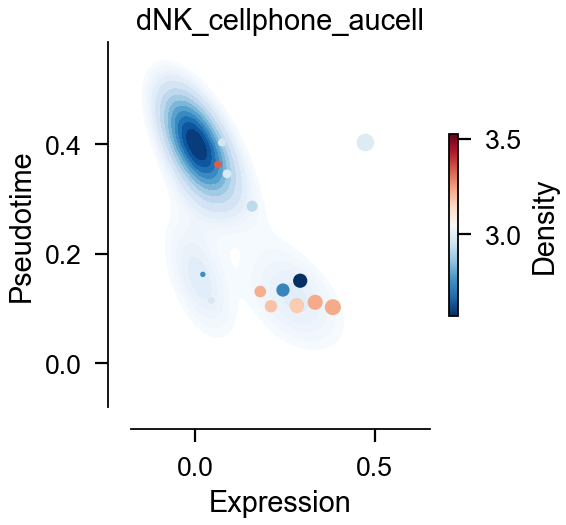

In [270]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3,3))

gene='dNK_cellphone_aucell'
visual_cluster=['SCT','EVT']

#x=ad[ad.obs['leiden'].isin(visual_cluster),gene].to_df().values.reshape(-1)
#y=ad.obs.loc[ad.obs['leiden'].isin(visual_cluster),'palantir_pseudotime'].values.reshape(-1)
#z=ad.obs.loc[ad.obs['leiden'].isin(visual_cluster),'mellon_log_density_lowd'].values.reshape(-1)

x=adata_aucs[adata_aucs.obs['celltype'].isin(visual_cluster),gene].to_df().values.reshape(-1)
y=adata_aucs.obs.loc[adata_aucs.obs['celltype'].isin(visual_cluster),'pt_via'].values.reshape(-1)
z=adata_aucs.obs.loc[adata_aucs.obs['celltype'].isin(visual_cluster),'mellon_log_density_lowd'].values.reshape(-1)

sns.kdeplot(
        x=x, y=y,
        fill=True,
        cmap='Blues',
        #clip=(-5, 5), cut=10,
        thresh=0.1, levels=15,
        ax=ax,#cbar=True,
    )
scatter=ax.scatter(x,y,
           c=z, s=x*100,
           cmap='RdBu_r',
                   #vmin=2.5,
          )

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

plt.xlabel('Expression',fontsize=13)
plt.ylabel('Pseudotime',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(gene,fontsize=13)
cbar = plt.colorbar(scatter, ax=ax,shrink=0.5)
cbar.set_label('Density', fontsize=13)
cbar.ax.tick_params(labelsize=12)

plt.savefig(f'figures/cpdb/evt_density_{gene}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/evt_density_{gene}.pdf',dpi=300,bbox_inches='tight')



In [268]:
adata_aucs.obs=adata_aucs.obs[adata_aucs.obs.columns[~adata_aucs.obs.columns.str.contains('aucell')]]

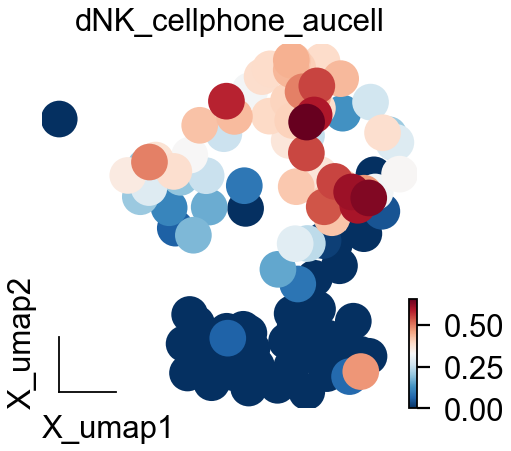

In [271]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))
ov.pl.embedding(
    adata_aucs,
    basis="X_umap",
    color=[gene],title=gene,
    show=False,  
    frameon='small',
    #size=10,
    #palette=ov.pl.green_color[:4]+ov.pl.blue_color[:5]+ov.pl.purple_color[:3]+ov.pl.orange_color[:5]+ov.pl.red_color[:4],
    ax=ax,
    legend_loc=None, add_outline=False, 
)

plt.savefig(f'figures/cpdb/umap_evt_density_{gene}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'pdf/cpdb/umap_evt_density_{gene}.pdf',dpi=300,bbox_inches='tight')


In [146]:
ov.plot_set()

All dependencies are satisfied.


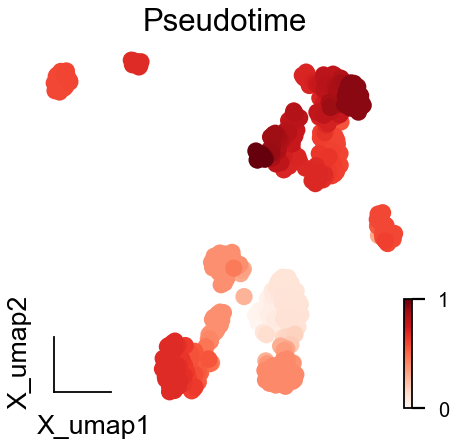

In [148]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(cp_ad,
                   basis='X_umap',
                   color=["pt_via"],
                   title='Pseudotime',
                   frameon='small',
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   cmap='Reds',
                   show=False)
fig.savefig("figures/cpdb/u_umap_pt_meta.png",dpi=300,bbox_inches = 'tight')
fig.savefig("pdf/cpdb/u_umap_pt_meta.pdf",dpi=300,bbox_inches = 'tight')


In [62]:
#cp_ad.write_h5ad('data/placenta/meta_evt_aucell.h5ad',compression='gzip')

In [33]:
other=list(set(adata.obs['celltype'].cat.categories)-set(['EVT','SCT','VCT']))

In [125]:
target_dict={}
target_dict_whole={}
for c in other:
    sub_means=ov.single.cpdb_exact_target(cpdb_results['means'],['EVT','SCT','EVT'])
    sub_means=ov.single.cpdb_exact_source(sub_means,[c])
    sub_means=sub_means.loc[~sub_means['gene_b'].isnull()]
    sub_means=sub_means.loc[~sub_means['gene_a'].isnull()]
    test=sub_means.iloc[:,10:]
    test.index=sub_means['gene_b']
    target_dict[c]=list(set(test.sum(axis=1)[test.mean(axis=1)>1].index))

    test.index=sub_means['interacting_pair']
    target_dict_whole[c]=list(set(test.sum(axis=1)[test.mean(axis=1)>1].index))
    
    

In [127]:
[i for i in target_dict_whole['dM'] if 'TNFRSF1B' in i]

['TNF_TNFRSF1B']

In [35]:
target_dict1=target_dict.copy()
for c in other:
    all_receptor=[]
    for j in other:
        if j==c:
            continue
        all_receptor+=target_dict[j]
        all_receptor=list(set(all_receptor))
    target_dict1[c]=list(set(target_dict1[c]) - set(all_receptor))

In [36]:
target_dict1

{'Epi': ['SLC22A17', 'STRA6'],
 'MO': [],
 'dNK': ['PLXNB1'],
 'dP': ['GJC1', 'VASN'],
 'ILC': ['CCR6'],
 'Endo': ['JAML',
  'CDH5',
  'VLDLR',
  'EPHA4',
  'ACKR4',
  'ADORA3',
  'GLG1',
  'EPHA7',
  'EPHA3',
  'TEK',
  'CD200R1',
  'EPHA2',
  'EPHA1',
  'FLT4'],
 'dS': ['FGFR2', 'C3AR1', 'C5AR2'],
 'Tcells': [],
 'Granulocytes': [],
 'DC': ['PLXND1'],
 'fFB': ['LGR5', 'MET', 'ROBO2', 'ROBO1', 'NOTCH1', 'NOTCH4', 'LGR6'],
 'dM': ['TNFRSF1B'],
 'NK': [],
 'Plasma': ['NTRK3', 'VIPR1', 'VIPR2'],
 'HB': ['TFRC', 'TREML2']}

In [280]:
pair_li=[]
for source_cell in ['dM','dNK','DC','HB']:
    for gene in target_dict1[source_cell]:
        for pair in [i for i in target_dict_whole[source_cell] if gene in i]:
            pair_li.append(pair)

In [281]:
t_means=cpdb_results['means']
t_means.loc[t_means['interacting_pair'].isin(pair_li)]

id_cp_interaction interacting_pair      partner_a      partner_b  gene_a  \
2152   CPI-SS044C72D0D    SEMA4A_PLXND1  simple:Q9H3S1  simple:Q9Y4D7  SEMA4A   
2157   CPI-SS0606E97F0    SEMA4D_PLXNB1  simple:Q92854  simple:O43157  SEMA4D   
2319   CPI-SS0FF0C7449         HFE_TFRC  simple:Q30201  simple:P02786     HFE   
2345   CPI-SS0E7D5974D     TNF_TNFRSF1B  simple:P01375  simple:P20333     TNF   
2851   CPI-SS0C724345A     CD276_TREML2  simple:Q5ZPR3  simple:Q5T2D2   CD276   

        gene_b  secreted  receptor_a  receptor_b annotation_strategy  ...  \
2152    PLXND1     False       False        True             curated  ...   
2157    PLXNB1      True        True        True             curated  ...   
2319      TFRC      True       False        True             curated  ...   
2345  TNFRSF1B      True       False        True             curated  ...   
2851    TREML2     False       False        True             curated  ...   

      fFB|NK fFB|Plasma fFB|SCT  fFB|Tcells  fFB|VCT  fFB|dM  fFB|dNK  fFB|dP  \
2152   0.257      0.194   0.243       0.181    0.301   0.871    0.215   0.569   
2157   0.022      0.000   0.216       0.023    0.522   0.031    0.026   0.074   
2319   0.112      0.428   1.994       0.147    1.537   0.793    0.213   0.194   
2345   0.566      0.445   0.206       0.446    0.045   1.064    0.358   0.236   
2851   0.687      0.712   0.749       0.686    0.685   0.685    0.684   0.685   

      fFB|dS  fFB|fFB  
2152   0.534    0.787  
2157   0.110    0.138  
2319   0.202    1.143  
2345   0.221    0.182  
2851   0.684    0.685  

[5 rows x 337 columns]

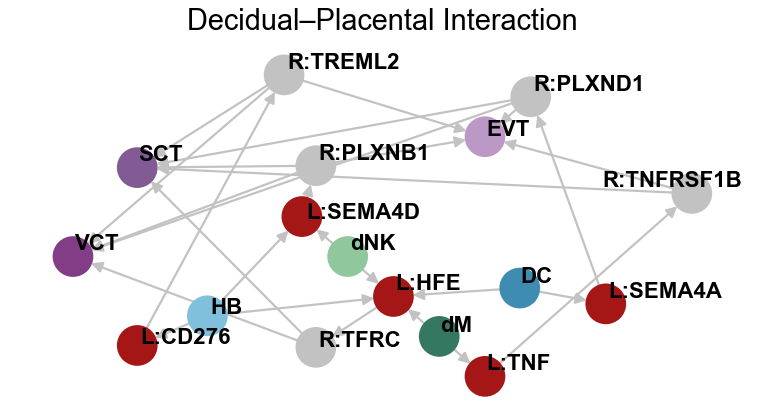

In [285]:
ov.pl.cpdb_interacting_network(adata=adata,
                         celltype_key='celltype',
                            means=t_means.loc[t_means['interacting_pair'].isin(pair_li)],
                            source_cells=['dNK','dM','DC','HB'],
                            target_cells=['EVT','SCT','VCT'],
                            means_min=1,
                             means_sum_min=1,        
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(6,3),
                            fontsize=10)
plt.title('Decidual–Placental Interaction',fontsize=13)
plt.savefig("figures/cpdb/network_cpdb_evt_inter.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/cpdb/network_cpdb_evt_inter.pdf",dpi=300,bbox_inches = 'tight')


In [293]:
adata.write('data/cpdb/evt_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 30000 × 21002
    obs: 'Fetus', 'location', 'final_cluster', 'annotation', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'celltype', 'Epi_cellphone_aucell', 'dNK_cellphone_aucell', 'dP_cellphone_aucell', 'ILC_cellphone_aucell', 'Endo_cellphone_aucell', 'dS_cellphone_aucell', 'DC_cellphone_aucell', 'fFB_cellphone_aucell', 'dM_cellphone_aucell', 'Plasma_cellphone_aucell', 'HB_cellphone_aucell'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet'
    obsm: 'X_mde_pca', 'scaled|original|X_pca', 'X_umap'
    layers: 'lognorm'

In [294]:
cp_ad.write('data/cpdb/evt_raw_cp_ad.h5ad')

In [295]:
SEACell_soft_ad.write('data/cpdb/evt_raw_SEACell_soft_ad.h5ad')